# RLID-NET 결과 시각화

가중치별 색상 표현:
- w0100에 가까울수록 빨간색
- w1000에 가까울수록 파란색


In [ ]:
import pandas as pd
import matplotlib.pyplot as pyplot
import numpy as np
import seaborn as sns
import os
import re
import glob as glob 


In [ ]:
# Constants
BASE_DIR = "./results"
WEIGHT_DIR = ["w0100", "w1090", "w2080", "w3070", "w4060", "w5050", "w6040","w7030","w8020", "w9010", "w1000"]
# WEIGHT_DIR = ["w0100", "w1090", "w2080", "w3070", "w4060", "w5050", "w100100", "w6040","w7030","w8020", "w9010", "w1000"]
WELL_REWARDED_DIR = "well_rewarded"


In [ ]:
def get_all_data(base_dir, weight_folders, well_rewarded_dir):
    all_data = []
    for weight in weight_folders:
        weight_path = os.path.join(base_dir, weight)
        # glob을 사용하여 패턴에 맞는 모든 Excel 파일 경로를 한 번에 찾습니다.
        search_pattern = os.path.join(weight_path, well_rewarded_dir, '_batch_*', 'lid_placement_summary.xlsx')
        file_paths = glob.glob(search_pattern)
        
        for file_path in file_paths:
            try:
                #  'Summary' 시트를 읽고 첫 번째 열을 인덱스로 설정합니다.
                df_summary = pd.read_excel(file_path, sheet_name='Summary', index_col=0)

                # 데이터를 전치(Transpose)합니다.
                df_transposed = df_summary.T

                # 필요한 열만 선택합니다.
                cols_to_keep = ['Total LID Cost (M KRW)', 'Total Runoff Reduction (m³)']
                df_selected = df_transposed[cols_to_keep].copy()

                # 'weight' 열을 추가합니다.
                df_selected['weight'] = weight

                all_data.append(df_selected)
            except Exception as e:
                print(f"Error reading or processing {file_path}: {e}")
    
    if not all_data:
        return pd.DataFrame()
        
    return pd.concat(all_data, ignore_index=True)


In [ ]:
# 데이터 로드
all_lid_data = get_all_data(BASE_DIR, WEIGHT_DIR, WELL_REWARDED_DIR)
print(all_lid_data.head())
print(f"Loaded {len(all_lid_data)} data points.")


Metric Total LID Cost (M KRW) Total Runoff Reduction (m³) weight
0                        2253                   22.996773  w0100
1                        2592                   22.351156  w0100
2                      1342.5                  189.770357  w0100
3                      1087.5                   74.221044  w0100
4                        5154                   92.360477  w0100
Loaded 129 data points.


In [ ]:
# 데이터 타입 정리 (for numerical analysis)
print("데이터 타입을 숫자로 변환합니다...")
num_cols = ['Total LID Cost (M KRW)', 'Total Runoff Reduction (m³)']
for col in num_cols:
    # 쉼표 등을 제거하고 숫자 타입으로 변경
    all_lid_data[col] = pd.to_numeric(
        all_lid_data[col].astype(str).str.replace(',', '').str.strip(),
        errors='coerce'  # 변환할 수 없는 값은 NaT/NaN으로 처리
    )

   # 숫자 변환에 실패한 행이 있다면 제거
original_len = len(all_lid_data)
all_lid_data.dropna(subset=num_cols, inplace=True)
new_len = len(all_lid_data)

if original_len > new_len:
    print(f"숫자가 아닌 데이터를 포함한 {original_len - new_len}개의 행을제거했습니다.")

print("데이터 정제 완료.")

데이터 타입을 숫자로 변환합니다...
데이터 정제 완료.


=== 가중치 기반 색상 산점도 (w0100=빨강, w1000=파랑) ===


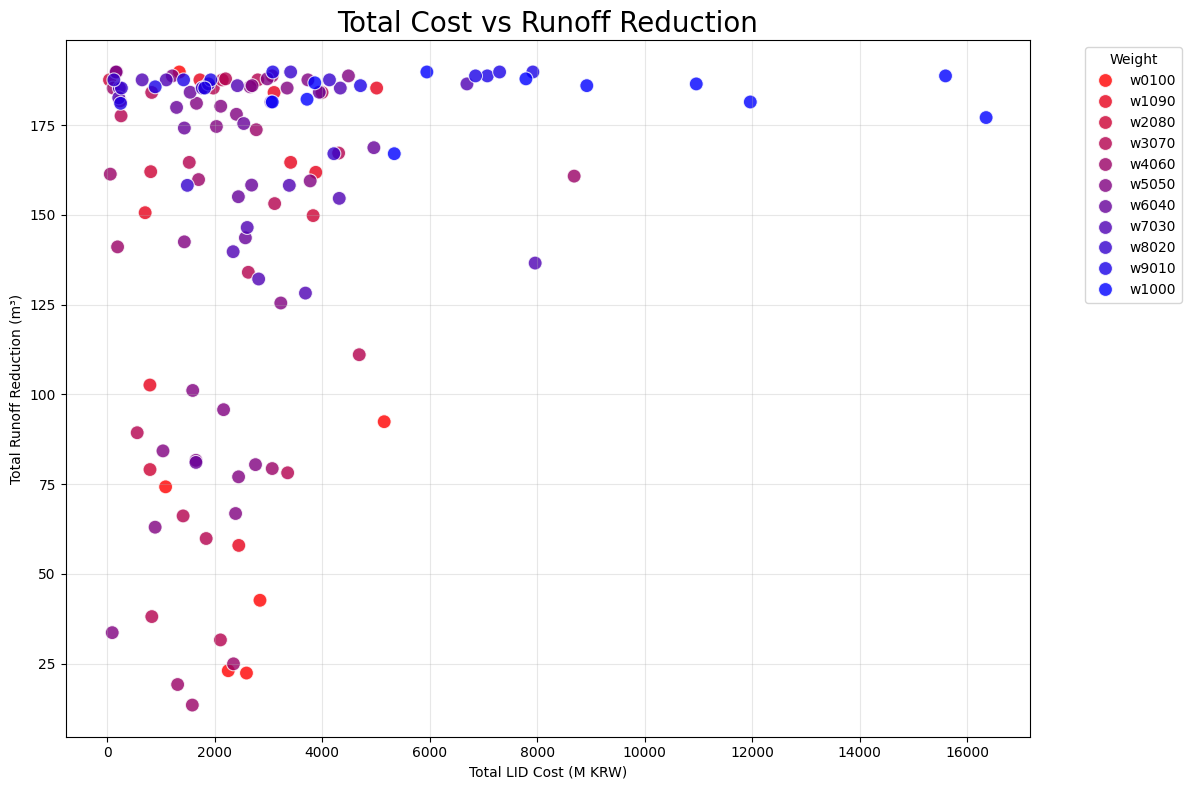

In [ ]:
# 가중치 기반 색상(빨강→파랑)으로 산점도 그리기
print("=== 가중치 기반 색상 산점도 (w0100=빨강, w1000=파랑) ===")

# 가중치 팔레트 생성 (셀 독립 실행 가능하도록 여기서 생성)
weights = WEIGHT_DIR
n = len(weights)
_weight_color_mapping = {}
for i, w in enumerate(weights):
    t = i / (n - 1) if n > 1 else 0.5
    r = 1.0 * (1 - t) + 0.0 * t  # 빨강→파랑 그라데이션
    g = 0.0
    b = 0.0 * (1 - t) + 1.0 * t
    _weight_color_mapping[w] = (r, g, b, 0.7)
_weight_palette = {w: _weight_color_mapping[w][:3] for w in weights}

pyplot.figure(figsize=(12, 8))
sns.scatterplot(
    data=all_lid_data,
    x='Total LID Cost (M KRW)',
    y='Total Runoff Reduction (m³)',
    hue='weight',
    palette=_weight_palette,
    s=100,
    alpha=0.8
)
pyplot.title('Total Cost vs Runoff Reduction', fontsize=20)
pyplot.xlabel('Total LID Cost (M KRW)')
pyplot.ylabel('Total Runoff Reduction (m³)')
pyplot.grid(True, alpha=0.3)
pyplot.legend(title='Weight', bbox_to_anchor=(1.05, 1), loc='upper left')
pyplot.tight_layout()
pyplot.show()


In [ ]:
# 가중치별 색상 매핑 함수
def get_weight_color_mapping(weight_folders):
    """
    가중치 폴더 리스트를 받아서 색상 매핑을 반환
    WEIGHT_DIR 순서를 그대로 사용하여 w0100=빨간색, w1000=파란색
    """
    # 색상 매핑 딕셔너리 생성
    color_mapping = {}
    num_weights = len(weight_folders)
    
    print(f"Weight order: {weight_folders}")
    
    for i, weight in enumerate(weight_folders):
        # 0-1 범위로 정규화 (첫 번째=0, 마지막=1)
        if num_weights == 1:
            normalized = 0.5
        else:
            normalized = i / (num_weights - 1)
        
        # 빨간색(1,0,0)에서 파란색(0,0,1)으로 그라데이션
        # 첫 번째(w0100)에 가까울수록 빨간색, 마지막(w1000)에 가까울수록 파란색
        red = 1 - normalized  # 첫 번째일 때 1, 마지막일 때 0
        blue = normalized     # 첫 번째일 때 0, 마지막일 때 1
        
        color_mapping[weight] = (red, 0, blue, 0.7)  # (R, G, B, Alpha)
        print(f"{weight}: normalized={normalized:.3f}, color=({red:.3f}, 0, {blue:.3f})")
    
    return color_mapping

# 색상 매핑 생성
weight_color_mapping = get_weight_color_mapping(WEIGHT_DIR)


Weight order: ['w0100', 'w1090', 'w2080', 'w3070', 'w4060', 'w5050', 'w6040', 'w7030', 'w8020', 'w9010', 'w1000']
w0100: normalized=0.000, color=(1.000, 0, 0.000)
w1090: normalized=0.100, color=(0.900, 0, 0.100)
w2080: normalized=0.200, color=(0.800, 0, 0.200)
w3070: normalized=0.300, color=(0.700, 0, 0.300)
w4060: normalized=0.400, color=(0.600, 0, 0.400)
w5050: normalized=0.500, color=(0.500, 0, 0.500)
w6040: normalized=0.600, color=(0.400, 0, 0.600)
w7030: normalized=0.700, color=(0.300, 0, 0.700)
w8020: normalized=0.800, color=(0.200, 0, 0.800)
w9010: normalized=0.900, color=(0.100, 0, 0.900)
w1000: normalized=1.000, color=(0.000, 0, 1.000)


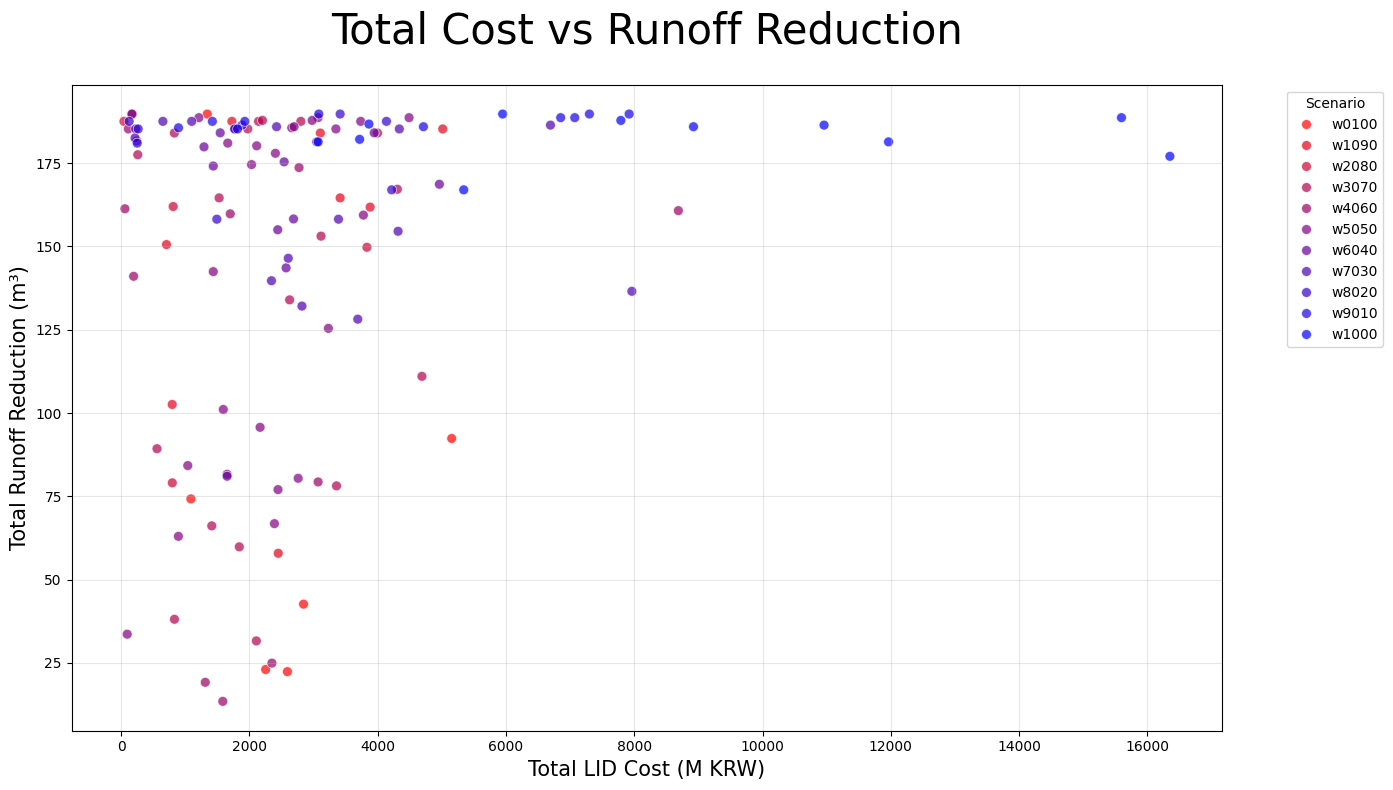

In [ ]:
# 2. Seaborn을 사용한 Scatter Plot (가중치별 색상)
pyplot.figure(figsize=(14, 8))

# 가중치별 색상 팔레트 생성
weight_palette = {weight: weight_color_mapping[weight][:3] for weight in WEIGHT_DIR}

# Seaborn scatter plot
sns.scatterplot(
    data=all_lid_data,
    x='Total LID Cost (M KRW)',
    y='Total Runoff Reduction (m³)',
    hue='weight',
    palette=weight_palette,
    s=50,
    alpha=0.7
)

pyplot.title('Total Cost vs Runoff Reduction', fontsize=30, pad=30)
pyplot.xlabel('Total LID Cost (M KRW)', fontsize=15)
pyplot.ylabel('Total Runoff Reduction (m³)', fontsize=15)
pyplot.grid(True, alpha=0.3)
pyplot.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
pyplot.tight_layout()
pyplot.show()


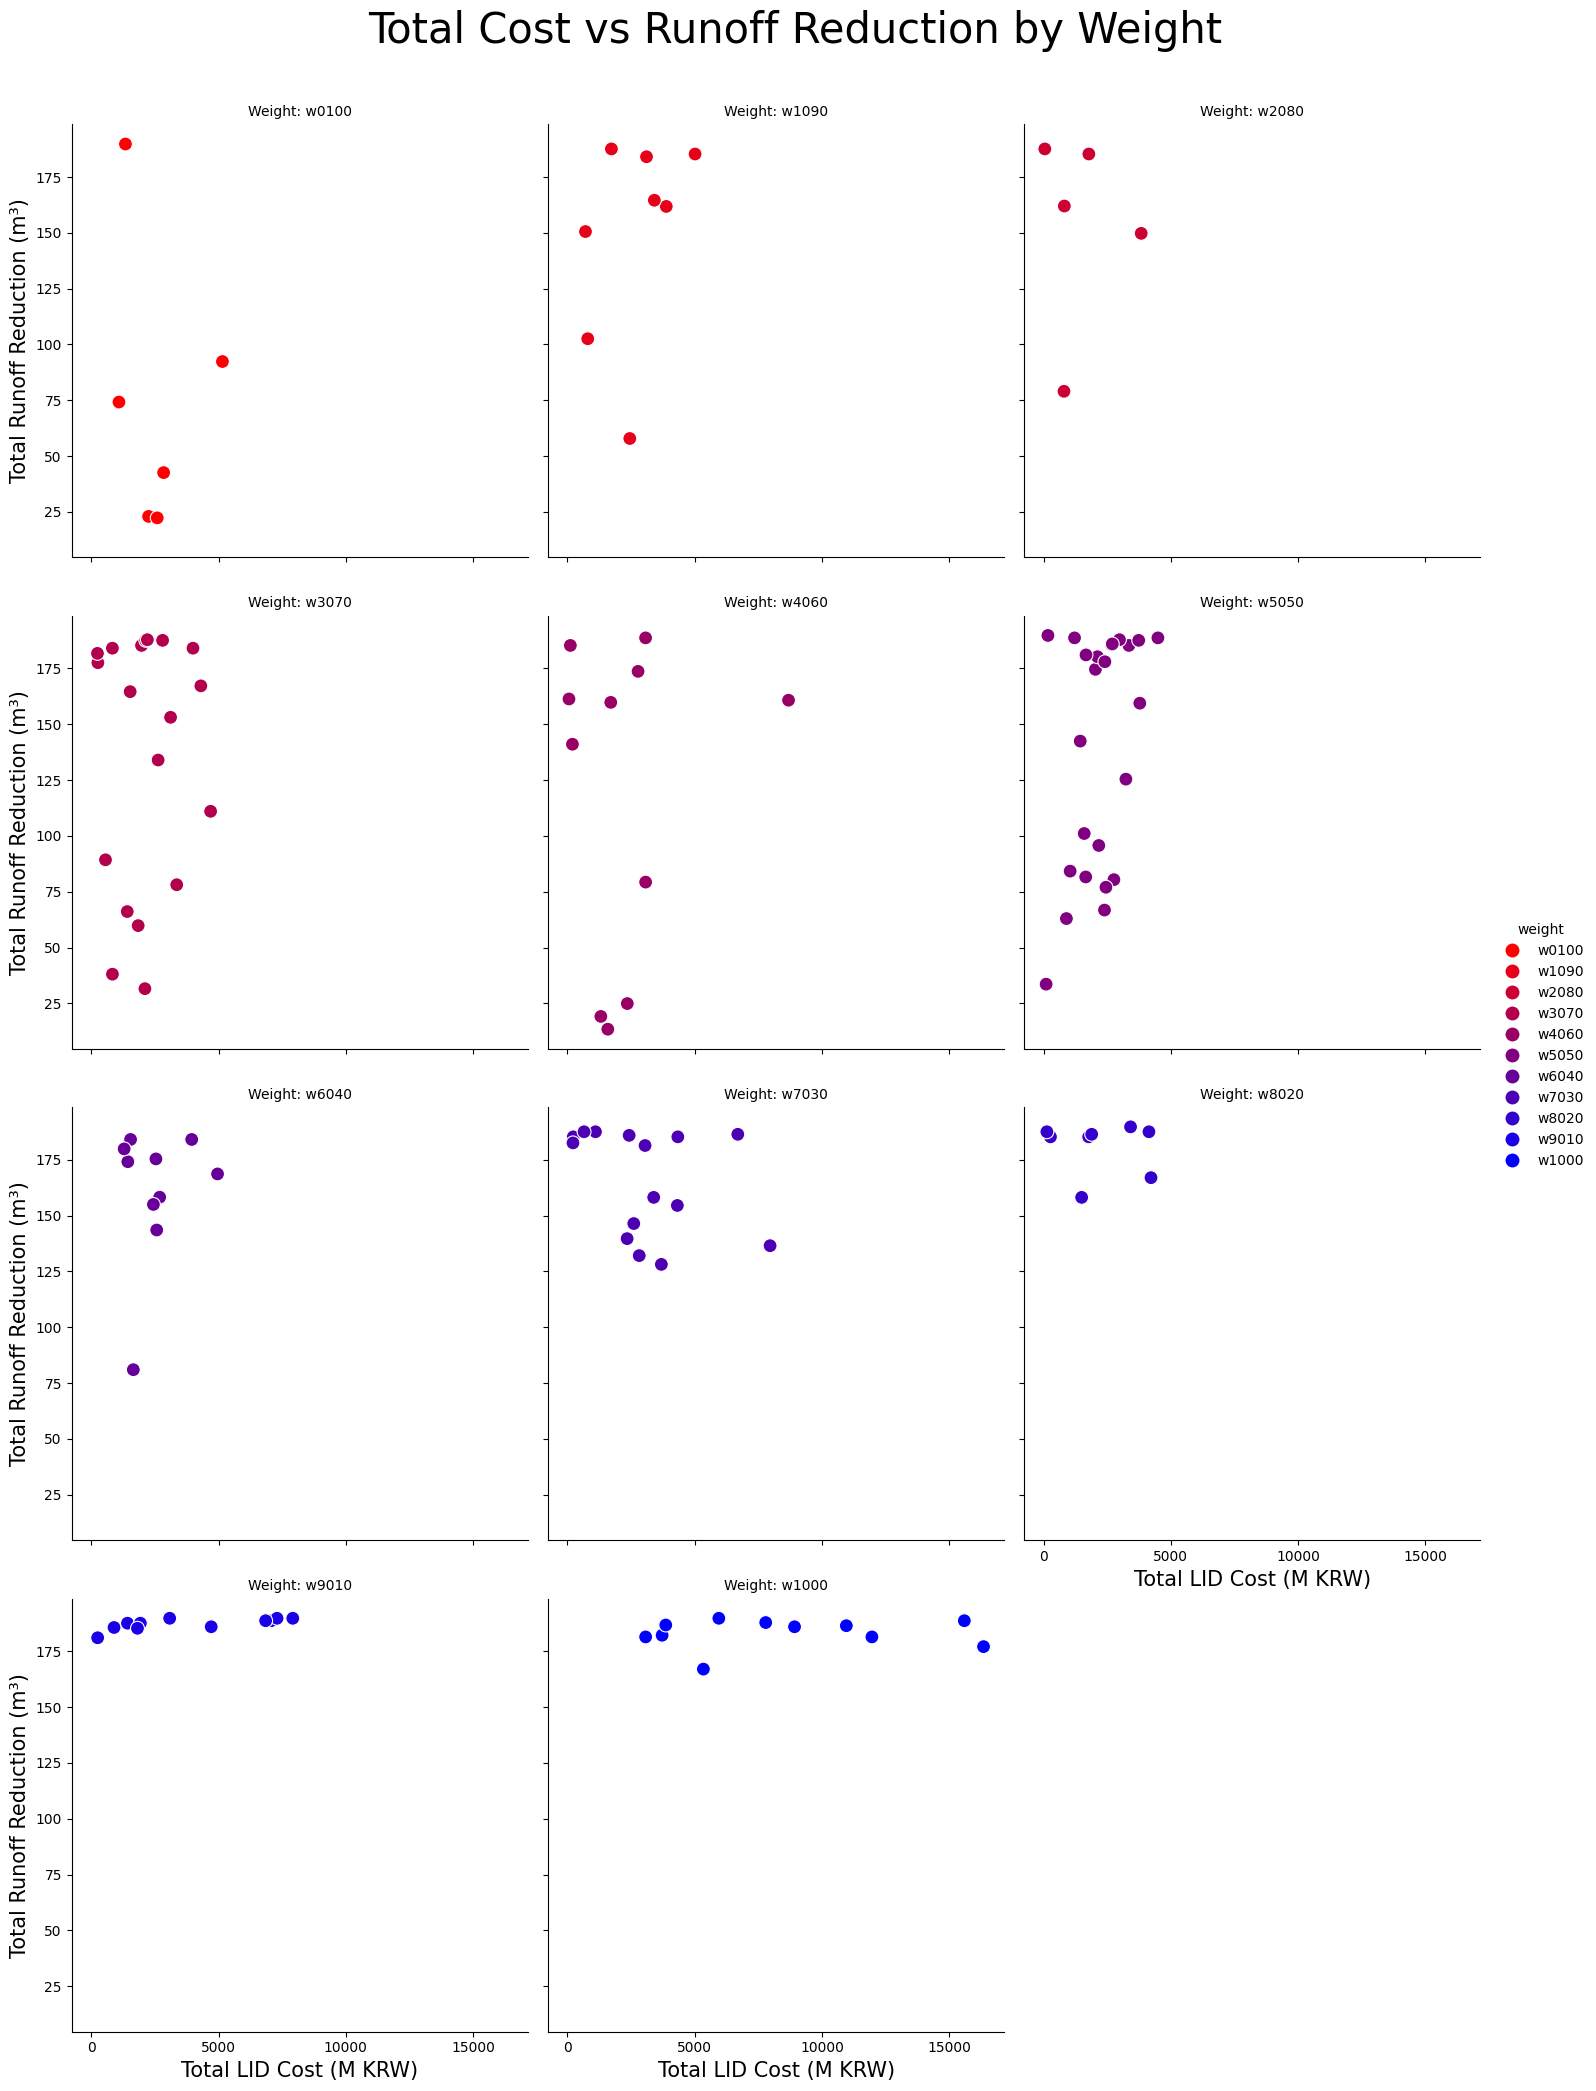

In [ ]:
# 3. Faceted Scatter Plot (가중치별 서브플롯, 올바른 순서)
# 가중치별 색상 팔레트 생성
weight_palette = {weight: weight_color_mapping[weight][:3] for weight in WEIGHT_DIR}

g = sns.relplot(
    data=all_lid_data,
    x='Total LID Cost (M KRW)',
    y='Total Runoff Reduction (m³)',
    col='weight',  # Create a column of subplots for each weight
    col_wrap=3,    # Wrap the subplots into 3 columns
    hue='weight',  # Still color by weight for consistency
    palette=weight_palette,  # 가중치별 색상 사용
    s=100,
    alpha=1,
    kind='scatter',
    # legend=False, 
    col_order=WEIGHT_DIR  # 올바른 순서로 서브플롯 배치
)
# Adjust titles and labels for clarity
g.fig.suptitle('Total Cost vs Runoff Reduction by Weight', y=1.04, fontsize = 30) # Main title
g.set_axis_labels('Total LID Cost (M KRW)', 'Total Runoff Reduction (m³)', fontsize = 15)

g.set_titles("Weight: {col_name}", fontsize = 18)
sns.set_context("talk")
pyplot.show()


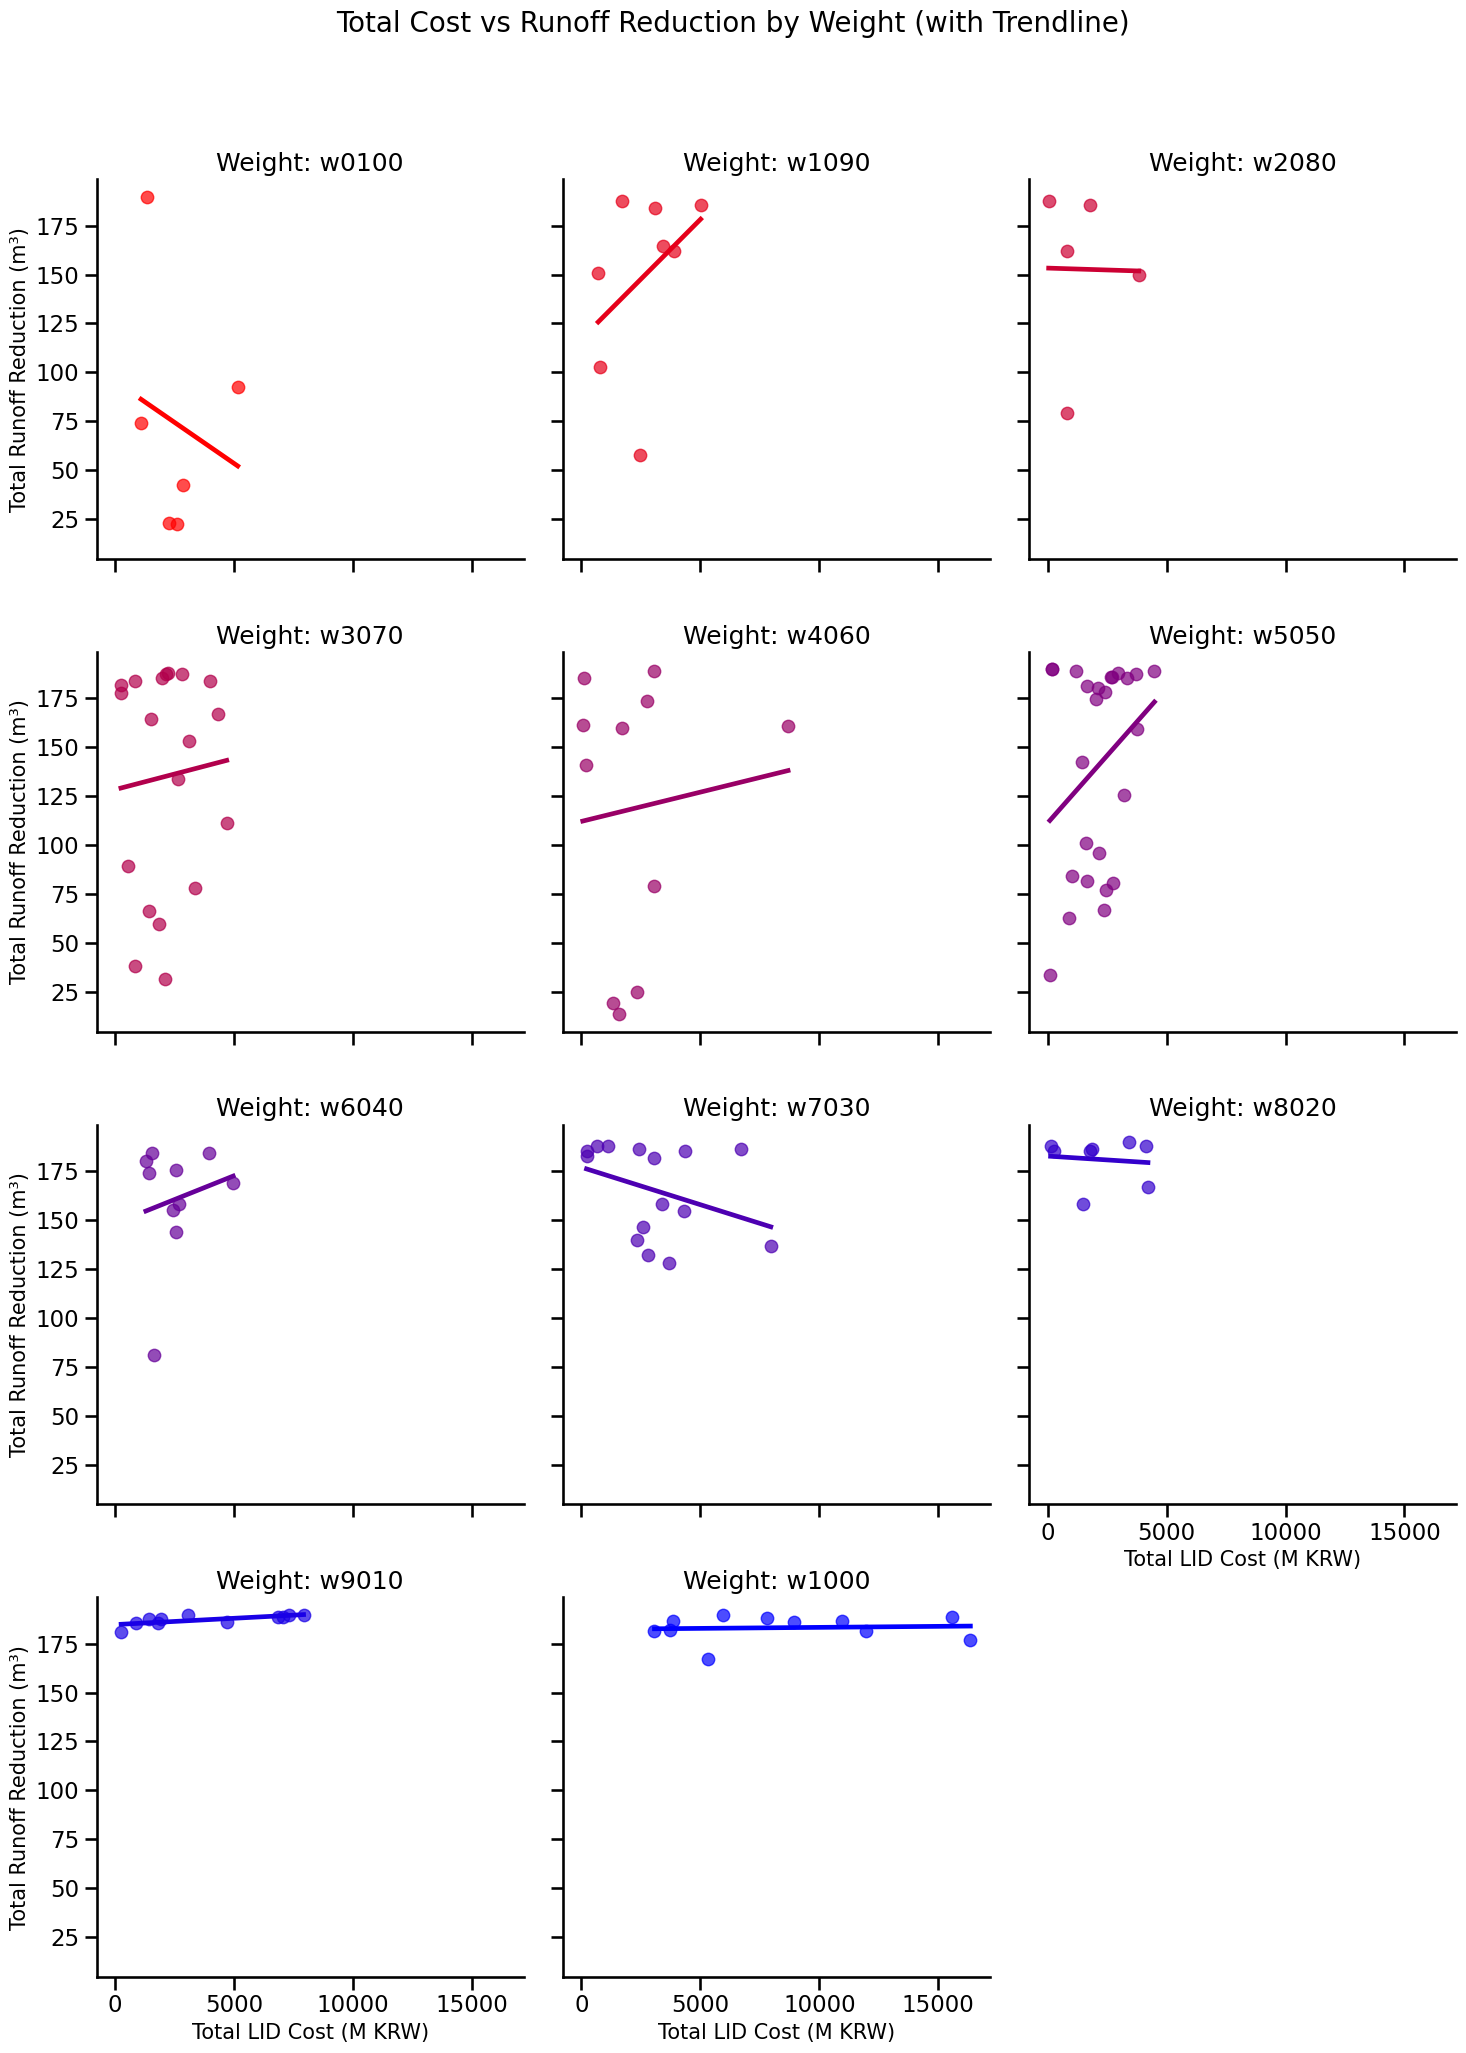

In [ ]:
# 3. Faceted Scatter Plot with Trendline (가중치별 서브플롯 + 추세선)
# 가중치별 색상 팔레트 생성
weight_palette = {weight: weight_color_mapping[weight][:3] for weight in WEIGHT_DIR}
# lmplot을 사용하여 산점도와 회귀선을 함께 그립니다.
g = sns.lmplot(
    data=all_lid_data,
    x='Total LID Cost (M KRW)',
    y='Total Runoff Reduction (m³)',
    col='weight',          # 가중치별로 플롯을 나눔
    col_wrap=3,            # 3개의 열로 배열
    hue='weight',          # 가중치별로 색상 구분
    palette=weight_palette,  # 정의된 색상 팔레트 사용
    col_order=WEIGHT_DIR,  # 올바른 순서로 서브플롯 배치
    ci=None,               # 신뢰구간(confidence interval) 표시 안 함
    scatter_kws={'s': 80, 'alpha': 0.7}, # 점 크기 및 투명도 조절
    legend=False
   )

   # Adjust titles and labels for clarity
g.fig.suptitle('Total Cost vs Runoff Reduction by Weight (with Trendline)', y=1.03, fontsize=20) # Main title
g.set_axis_labels('Total LID Cost (M KRW)', 'Total Runoff Reduction (m³)',fontsize=15)
g.set_titles("Weight: {col_name}", fontsize=18)

sns.set_context("talk")
pyplot.tight_layout()
pyplot.show()

군집화 완료.
군집화 결과를 시각화합니다...


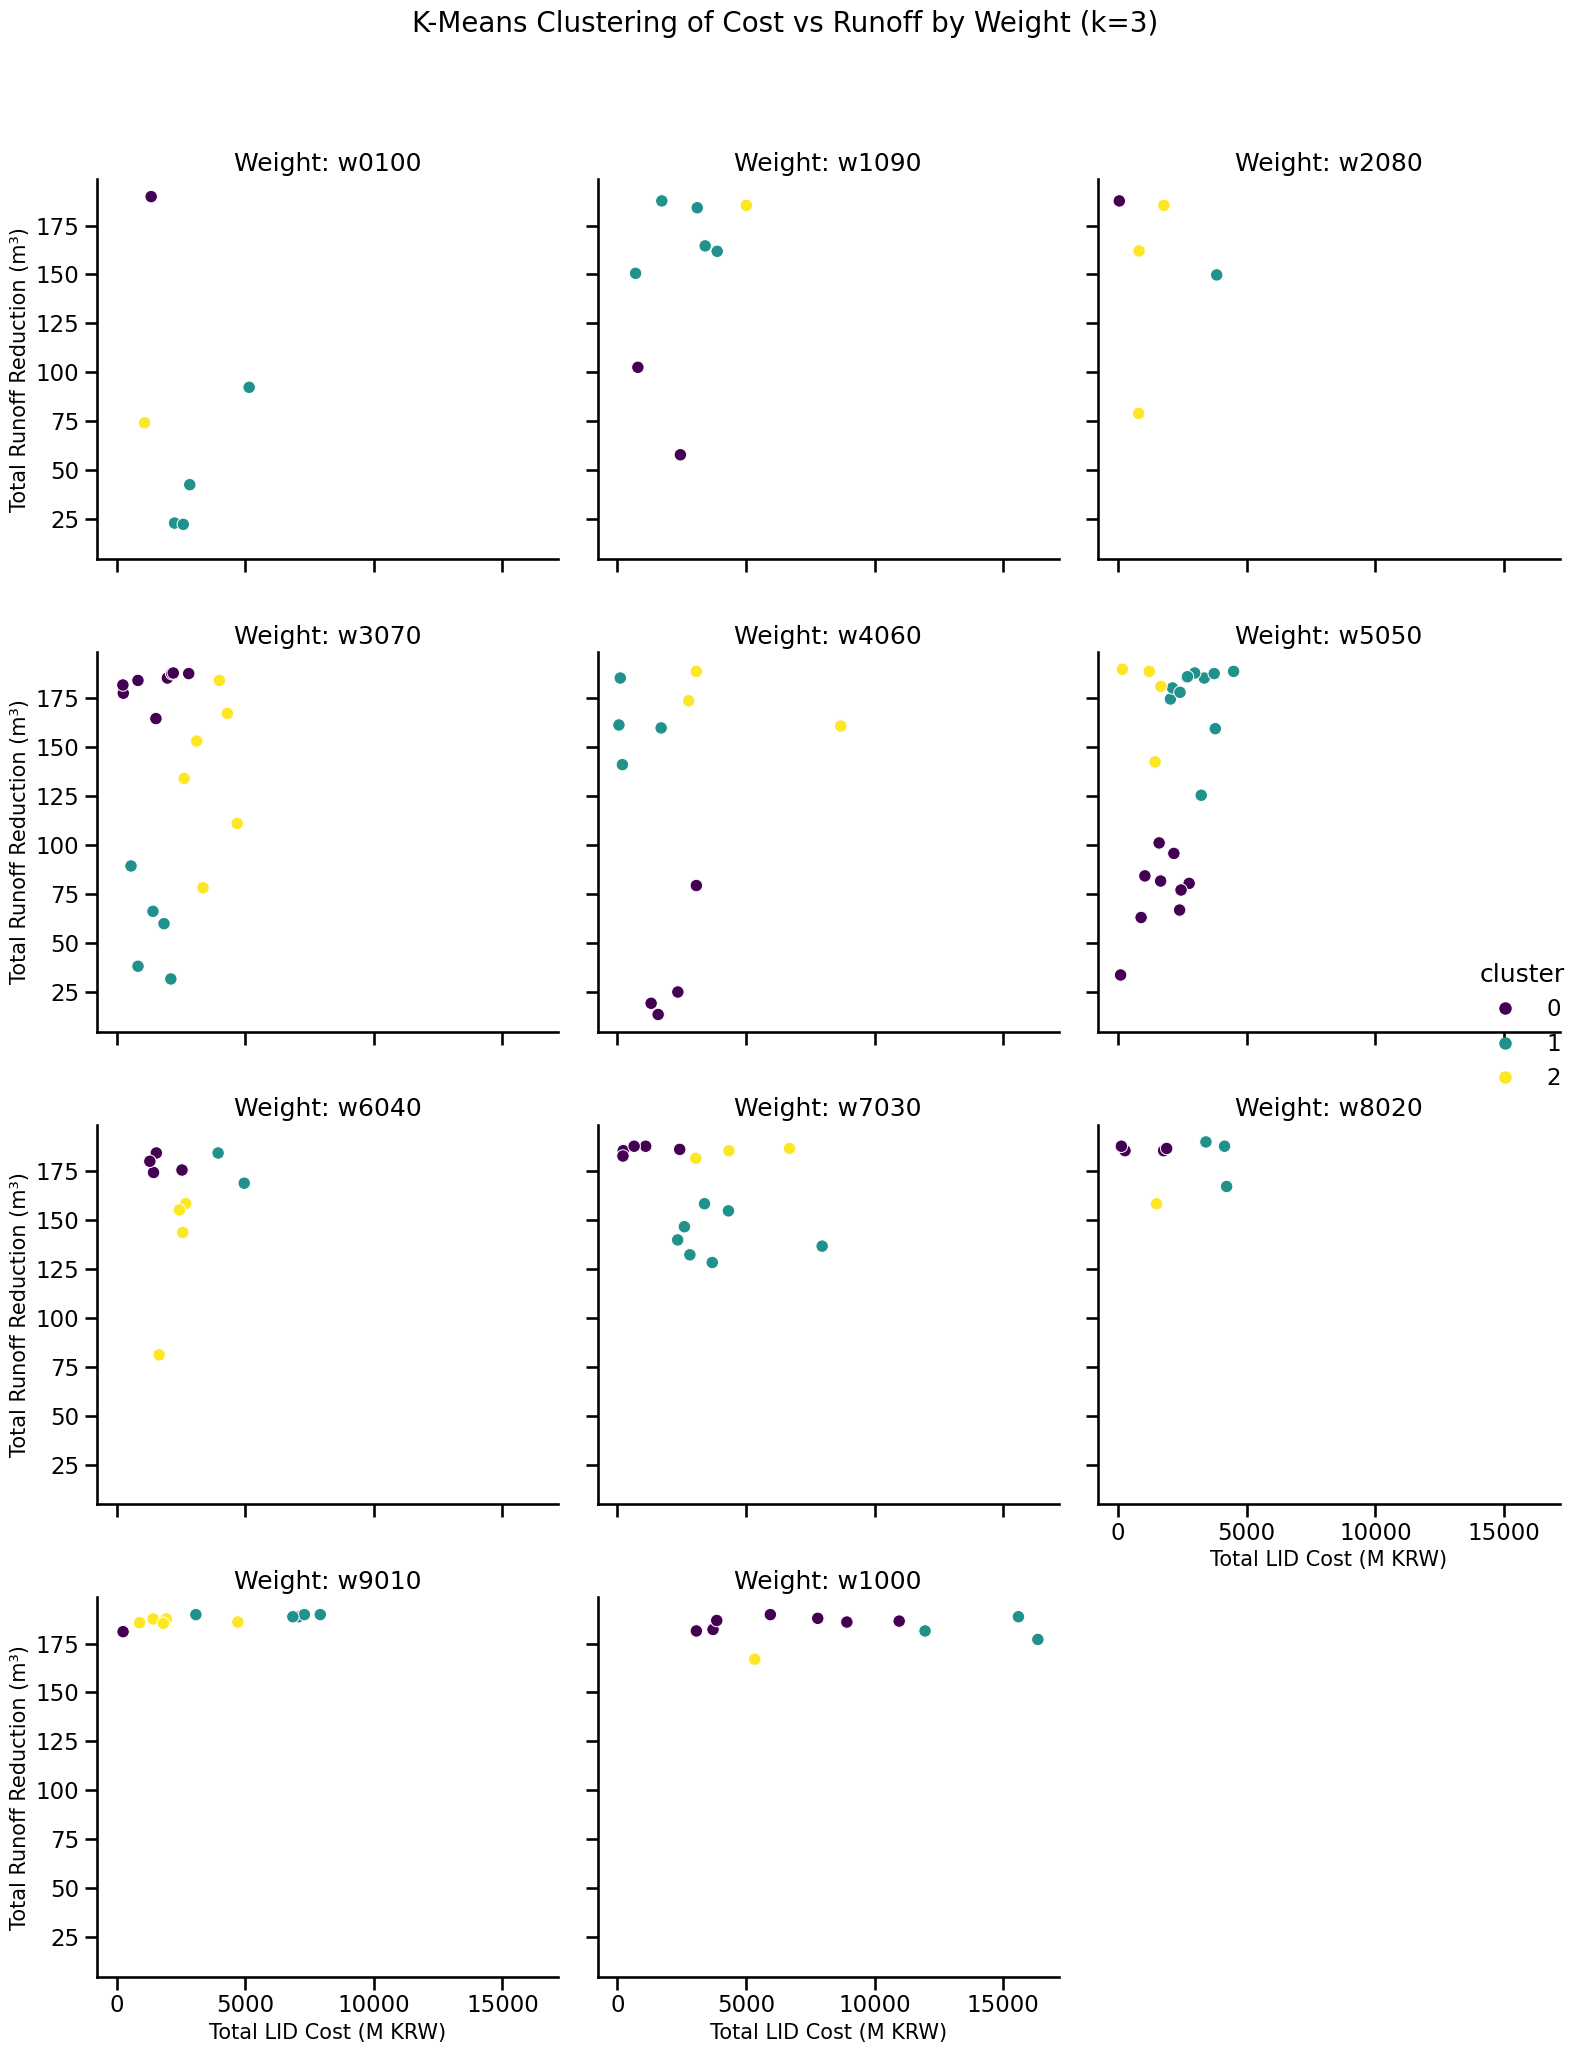

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. 데이터 준비 및 군집화 수행
# 군집화 결과를 저장할 'cluster' 열을 추가합니다.
all_lid_data['cluster'] = -1
# 분석할 특성을 선택합니다.
features = ['Total LID Cost (M KRW)', 'Total Runoff Reduction (m³)']
# 각 가중치별로 순회하며 군집화를 수행합니다.
for weight in WEIGHT_DIR:
    # 현재 가중치에 해당하는 데이터만 필터링합니다.
    weight_data_indices = all_lid_data[all_lid_data['weight'] == weight].index
    if len(weight_data_indices) < 3:  # 군집화하기에 데이터가 너무 적으면건너뜁니다.
        continue
    # 클러스터링할 데이터를 준비합니다.
    weight_features = all_lid_data.loc[weight_data_indices, features]
    # 중요: K-Means는 값의 범위(scale)에 민감하므로, 데이터를 표준화합니다.
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(weight_features)
    # K-Means 모델을 생성하고 학습합니다. (여기서는 3개의 군집으로 가정)
    # 참고: 최적의 군집 개수(k)는 'Elbow Method' 등으로 찾을 수 있습니다.
    kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
    clusters = kmeans.fit_predict(scaled_features)
    # 원본 데이터프레임에 군집 결과를 할당합니다.
    all_lid_data.loc[weight_data_indices, 'cluster'] = clusters
print("군집화 완료.")
# 2. 군집화 결과 시각화
print("군집화 결과를 시각화합니다...")
# relplot을 사용하여 가중치별로 군집화된 산점도를 그립니다.
g = sns.relplot(
    data=all_lid_data[all_lid_data['cluster'] != -1],  # 군집화된 데이터만 사용
    x='Total LID Cost (M KRW)',
    y='Total Runoff Reduction (m³)',
    hue='cluster',         # 군집 ID에 따라 색상을 다르게 표시
    col='weight',          # 가중치별로 플롯을 나눔
    col_wrap=3,            # 3개의 열로 배열
    palette='viridis',     # 색상 팔레트 변경
    col_order=WEIGHT_DIR,  # 가중치 순서 유지
    legend='full'
)
# 그래프 제목 및 레이블 설정
g.fig.suptitle('K-Means Clustering of Cost vs Runoff by Weight (k=3)', y=1.03, fontsize=20)
g.set_axis_labels('Total LID Cost (M KRW)', 'Total Runoff Reduction (m³)', fontsize=15)
g.set_titles("Weight: {col_name}", fontsize=18)
pyplot.tight_layout()
pyplot.show()

=== 데이터 분포 형태 분석 (PCA 기반 최적 방향선) ===


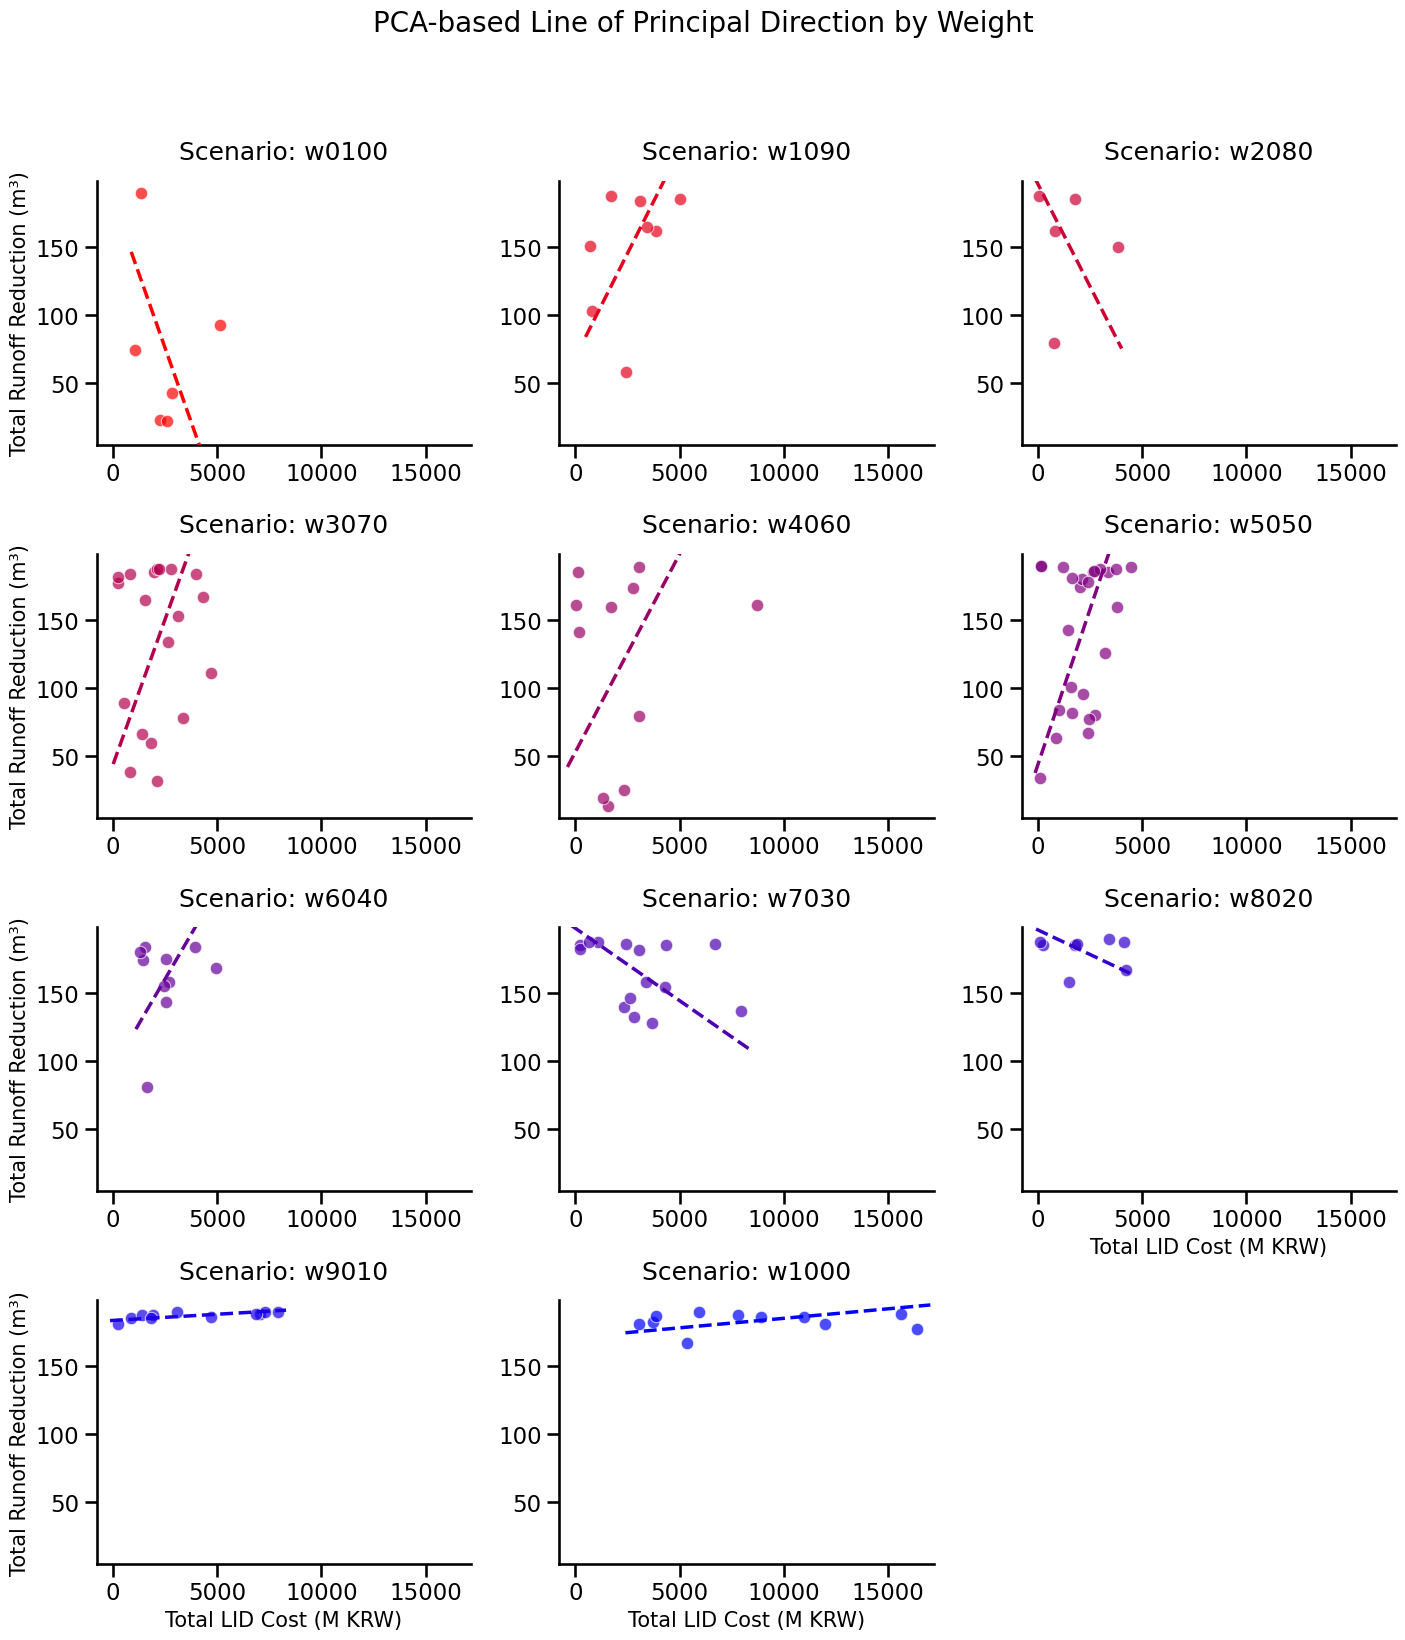

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
print("=== 데이터 분포 형태 분석 (PCA 기반 최적 방향선) ===")
# 가중치별 색상 팔레트
weight_palette = {weight: weight_color_mapping[weight][:3] for weight in WEIGHT_DIR}
# 1. 전체 데이터의 x, y 축 범위를 미리 계산하여 축을 고정합니다.
x_min = all_lid_data['Total LID Cost (M KRW)'].min()
x_max = all_lid_data['Total LID Cost (M KRW)'].max()
y_min = all_lid_data['Total Runoff Reduction (m³)'].min()
y_max = all_lid_data['Total Runoff Reduction (m³)'].max()
x_margin = (x_max - x_min) * 0.05
y_margin = (y_max - y_min) * 0.05
# 2. FacetGrid 객체를 생성하여 그래프의 전체 구조를 잡습니다.
g = sns.FacetGrid(all_lid_data, col="weight", col_wrap=3, hue="weight",palette=weight_palette, col_order=WEIGHT_DIR, height=4, aspect=1.2, sharex=False, sharey=False)
# 3. 각 서브플롯에 산점도를 그립니다.
g.map(sns.scatterplot, 'Total LID Cost (M KRW)', 'Total Runoff Reduction (m³)',s=80, alpha=0.7)
# 4. 각 서브플롯에 PCA 기반 방향선을 겹쳐 그립니다.
for i, ax in enumerate(g.axes.flat):
    if i >= len(WEIGHT_DIR):
        continue
    weight = WEIGHT_DIR[i]
    weight_data = all_lid_data[all_lid_data['weight'] == weight]
    if len(weight_data) < 2:
        continue
    features = ['Total LID Cost (M KRW)', 'Total Runoff Reduction (m³)']
    X = weight_data[features]
    # PCA는 스케일에 민감하므로, 방향 계산을 위해 내부적으로만 스케일링을사용합니다.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    pca.fit(X_scaled)
    # --- PCA 라인 그리기 로직 ---
    # 1. 원본 데이터의 평균점(중심점)을 구합니다.
    mean_original = X.mean().values
    # 2. 스케일링된 공간에서의 주성분(PC1) 방향 벡터를 구합니다.
    pc1_scaled = pca.components_[0]
    # 3. 원본 데이터의 표준편차를 가져옵니다.
    stds_original = scaler.scale_
    # 4. 원본 공간에서의 방향 벡터를 계산합니다 (스케일 복원).
    #    PC1의 각 요소에 해당 피처의 표준편차를 곱해 방향을 재계산합니다.
    direction_vector_original = pc1_scaled * stds_original
    # 5. 방향 벡터로부터 기울기를 계산합니다.
    #    (0으로 나누는 오류를 방지합니다)
    if direction_vector_original[0] == 0:
        # 기울기가 무한대일 경우 수직선을 그립니다.
        ax.axvline(x=mean_original[0], color=weight_palette[weight], linestyle='--', linewidth=2)
    else:
        slope = direction_vector_original[1] / direction_vector_original[0]
        # 6. y = m(x - x_mean) + y_mean 방정식을 사용하여 선을 그릴 두 점을계산합니다.
        x_vals = np.array(ax.get_xlim())
        y_vals = slope * (x_vals - mean_original[0]) + mean_original[1]
        # 7. 선을 그립니다.
        ax.plot(x_vals, y_vals, color=weight_palette[weight], linestyle='--',linewidth=2.5, zorder=10)

# 5. 전체 축의 범위를 통일합니다.
g.set(xlim=(x_min - x_margin, x_max + x_margin), ylim=(y_min - y_margin, y_max +y_margin))
# 전체 그래프 제목 및 레이블 설정
g.fig.suptitle('PCA-based Line of Principal Direction by Weight', y=1.03,fontsize=20)
g.set_axis_labels('Total LID Cost (M KRW)', 'Total Runoff Reduction (m³)',fontsize=15)
g.set_titles("Scenario: {col_name}", fontsize=18, y=1.05)

pyplot.tight_layout()
pyplot.show()

=== 모든 가중치의 PCA 방향선을 하나의 그래프에 시각화 (길이 및 스타일수정) ===


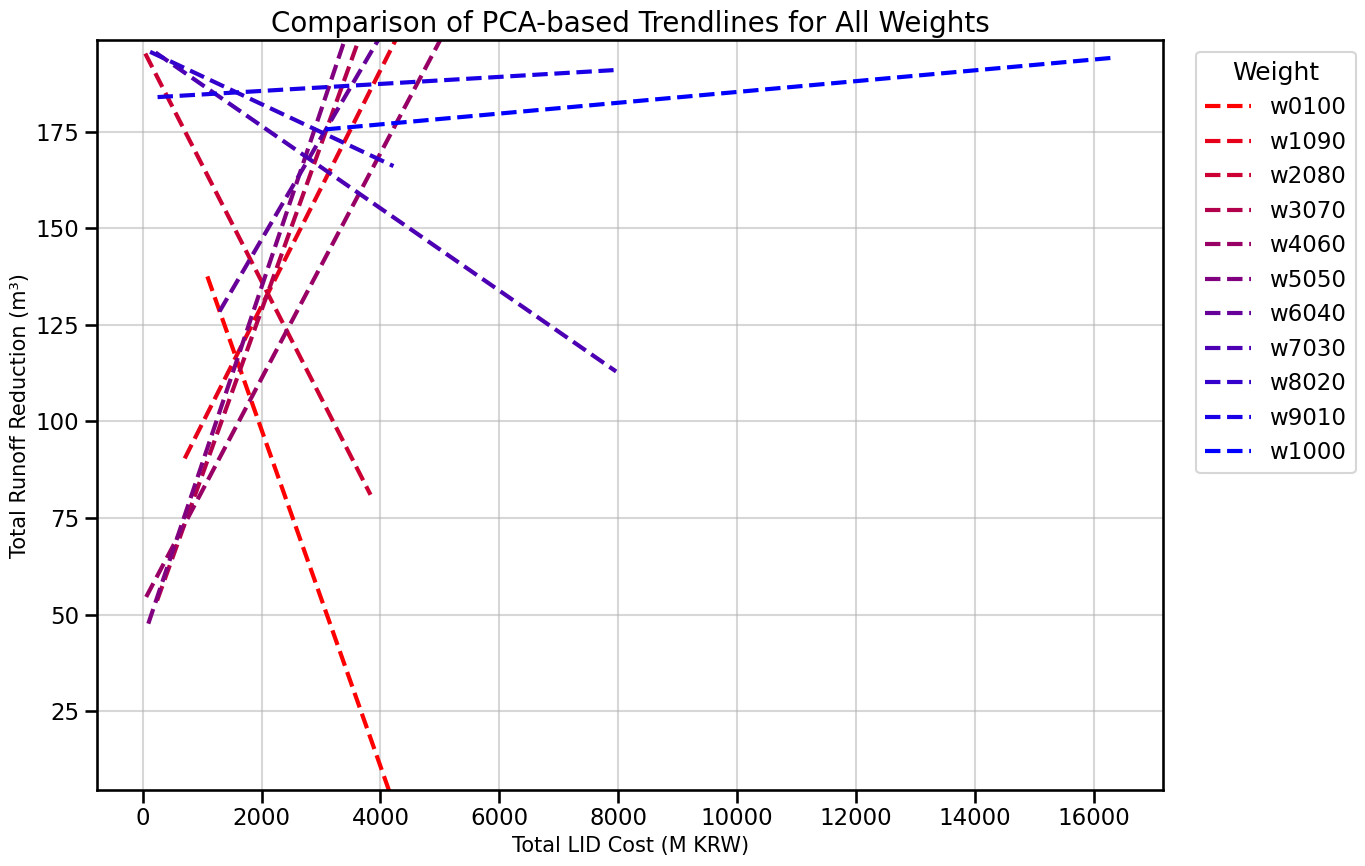

In [ ]:
print("=== 모든 가중치의 PCA 방향선을 하나의 그래프에 시각화 (길이 및 스타일수정) ===")
# 1. 새 그래프(Figure)와 축(Axes)을 생성합니다.
fig, ax = pyplot.subplots(figsize=(14, 9))
# 2. 전체 데이터의 축 범위를 설정하여 모든 데이터가 보이도록 합니다.
x_min_global = all_lid_data['Total LID Cost (M KRW)'].min()
x_max_global = all_lid_data['Total LID Cost (M KRW)'].max()
y_min_global = all_lid_data['Total Runoff Reduction (m³)'].min()
y_max_global = all_lid_data['Total Runoff Reduction (m³)'].max()
x_margin = (x_max_global - x_min_global) * 0.05
y_margin = (y_max_global - y_min_global) * 0.05
ax.set_xlim(x_min_global - x_margin, x_max_global + x_margin)
ax.set_ylim(y_min_global - y_margin, y_max_global + y_margin)

# 3. 각 가중치별로 PCA를 계산하고, 해당 데이터 범위 내에서만 점선으로 그립니다.
for weight in WEIGHT_DIR:
    weight_data = all_lid_data[all_lid_data['weight'] == weight]

    if len(weight_data) < 2:
        continue

    features = ['Total LID Cost (M KRW)', 'Total Runoff Reduction (m³)']
    X = weight_data[features]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    pca.fit(X_scaled)

    mean_original = X.mean().values
    pc1_scaled = pca.components_[0]
    stds_original = scaler.scale_
    direction_vector_original = pc1_scaled * stds_original

    if direction_vector_original[0] != 0:
        slope = direction_vector_original[1] / direction_vector_original[0]

        # --- 수정된 부분: 해당 가중치 데이터의 x범위 내에서만 선을 그리도록x_vals를 계산 ---
        x_min_weight = X['Total LID Cost (M KRW)'].min()
        x_max_weight = X['Total LID Cost (M KRW)'].max()
        x_vals = np.array([x_min_weight, x_max_weight])
        y_vals = slope * (x_vals - mean_original[0]) + mean_original[1]
        # --- 수정된 부분: linestyle을 '--'(점선)으로 변경 ---
        ax.plot(x_vals, y_vals, color=weight_palette[weight], linestyle='--', linewidth=3, label=weight)

# 4. 그래프 제목, 레이블, 범례를 설정합니다.
ax.set_title('Comparison of PCA-based Trendlines for All Weights', fontsize=20)
ax.set_xlabel('Total LID Cost (M KRW)', fontsize=15)
ax.set_ylabel('Total Runoff Reduction (m³)', fontsize=15)
ax.grid(True, alpha=0.5)
ax.legend(title='Weight', bbox_to_anchor=(1.02, 1), loc='upper left')
pyplot.tight_layout()
pyplot.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_43776\3629786058.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


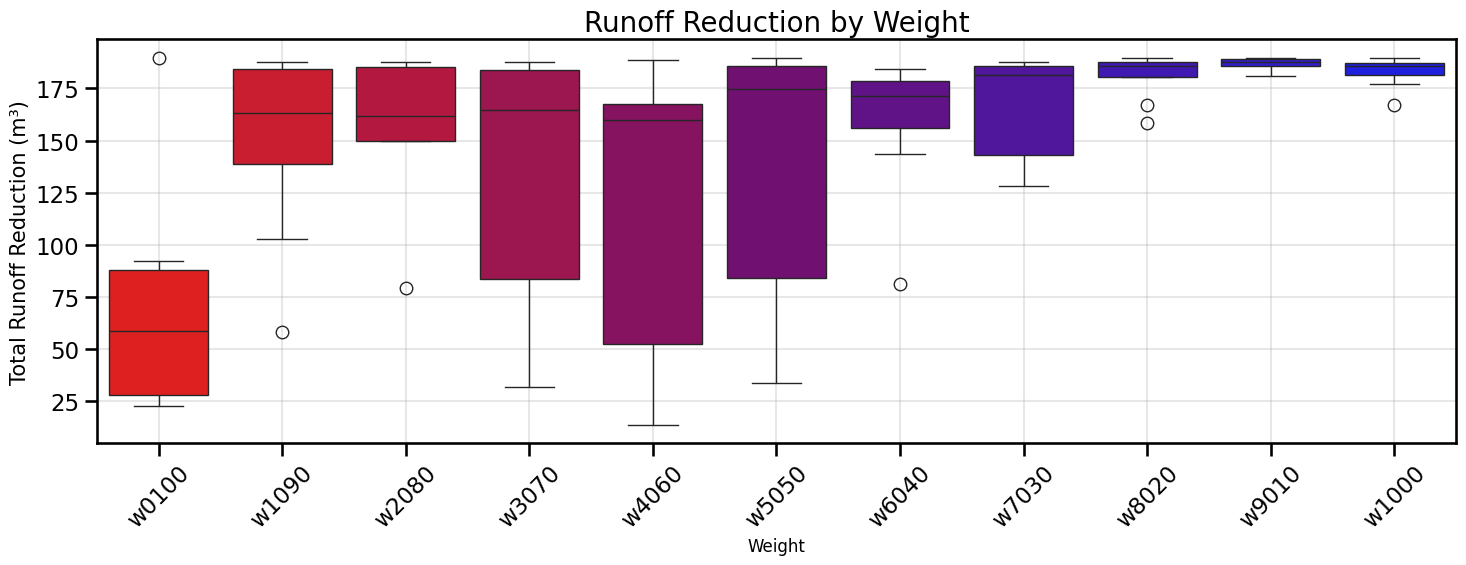

In [ ]:
# 4. 가중치별 박스플롯 (올바른 순서)
pyplot.figure(figsize=(15, 6))

# 가중치별 색상 팔레트 생성
weight_palette = {weight: weight_color_mapping[weight][:3] for weight in WEIGHT_DIR}

# 박스플롯 생성
sns.boxplot(
    data=all_lid_data,
    x='weight',
    y='Total Runoff Reduction (m³)',
    palette=weight_palette,
    order=WEIGHT_DIR  # 올바른 순서로 박스플롯 배치
)

pyplot.title('Runoff Reduction by Weight', fontsize=20)
pyplot.xlabel('Weight', fontsize=12)
pyplot.ylabel('Total Runoff Reduction (m³)', fontsize=15)
pyplot.xticks(rotation=45)
pyplot.grid(True, alpha=0.3)
pyplot.tight_layout()
pyplot.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_43776\4265880060.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


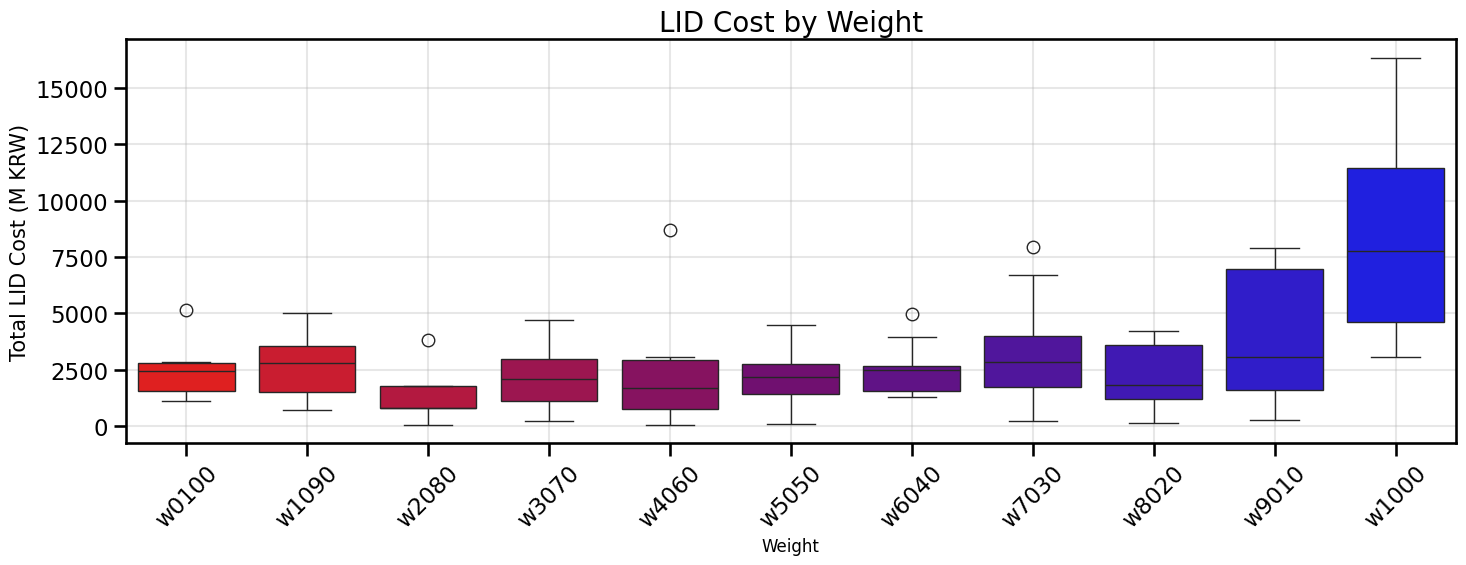

In [ ]:
# 5. 가중치별 비용 박스플롯 (올바른 순서)
pyplot.figure(figsize=(15, 6))

# 가중치별 색상 팔레트 생성
weight_palette = {weight: weight_color_mapping[weight][:3] for weight in WEIGHT_DIR}

# 박스플롯 생성
sns.boxplot(
    data=all_lid_data,
    x='weight',
    y='Total LID Cost (M KRW)',
    palette=weight_palette,
    order=WEIGHT_DIR  # 올바른 순서로 박스플롯 배치
)

pyplot.title('LID Cost by Weight', fontsize=20)
pyplot.xlabel('Weight', fontsize=12)
pyplot.ylabel('Total LID Cost (M KRW)', fontsize=15)
pyplot.xticks(rotation=45)
pyplot.grid(True, alpha=0.3)
pyplot.tight_layout()
pyplot.show()


In [ ]:
# 데이터 타입 정리 (nlargest/nsmallest 사용 준비)
print("=== 데이터 타입 정리 ===")
num_cols = ['Total LID Cost (M KRW)', 'Total Runoff Reduction (m³)']
for col in num_cols:
    # 문자열에 쉼표 등 제거 후 숫자로 변환
    all_lid_data[col] = pd.to_numeric(
        all_lid_data[col].astype(str).str.replace(',', '').str.strip(),
        errors='coerce'
    )

# 필요한 열에 NaN이 있으면 제외
before_len = len(all_lid_data)
all_lid_data = all_lid_data.dropna(subset=num_cols).reset_index(drop=True)
after_len = len(all_lid_data)
print(f"정리 전/후 데이터 수: {before_len} -> {after_len}")


=== 데이터 타입 정리 ===
정리 전/후 데이터 수: 129 -> 129


In [ ]:
# 세 점(좌상단/우상단/좌하단) 자동 선별
print("=== 세 점 자동 선별 ===")

# 효율성 계산(필요시)
if 'efficiency' not in all_lid_data.columns:
    all_lid_data['efficiency'] = all_lid_data['Total Runoff Reduction (m³)'] / all_lid_data['Total LID Cost (M KRW)']

# 1) 좌상단(이상점): 저비용 고성능
outlier_candidates = all_lid_data[
    (all_lid_data['Total LID Cost (M KRW)'] <= 600) &
    (all_lid_data['Total Runoff Reduction (m³)'] >= 140)
].nlargest(1, 'Total Runoff Reduction (m³)')

# 2) 우상단(성능점): 고비용 고성능
performance_candidates = all_lid_data[
    (all_lid_data['Total LID Cost (M KRW)'] >= 14000) &
    (all_lid_data['Total Runoff Reduction (m³)'] >= 150)
].nlargest(1, 'Total Runoff Reduction (m³)')

# 3) 좌하단(비용점): 저비용 저성능
cost_candidates = all_lid_data[
    (all_lid_data['Total LID Cost (M KRW)'] <= 2500) &
    (all_lid_data['Total Runoff Reduction (m³)'] <= 60)
].nsmallest(1, 'Total LID Cost (M KRW)')

selected_points_nb = {}
if len(outlier_candidates) > 0:
    selected_points_nb['outlier'] = outlier_candidates.iloc[0]
if len(performance_candidates) > 0:
    selected_points_nb['performance'] = performance_candidates.iloc[0]
if len(cost_candidates) > 0:
    selected_points_nb['cost'] = cost_candidates.iloc[0]

for k, p in selected_points_nb.items():
    print(f"{k}: weight={p['weight']}, cost={p['Total LID Cost (M KRW)']:.1f}, perf={p['Total Runoff Reduction (m³)']:.1f}")


=== 세 점 자동 선별 ===
outlier: weight=w5050, cost=175.5, perf=189.8
performance: weight=w1000, cost=15597.0, perf=188.7
cost: weight=w5050, cost=94.5, perf=33.6


=== 세 점 산점도 오버레이 ===


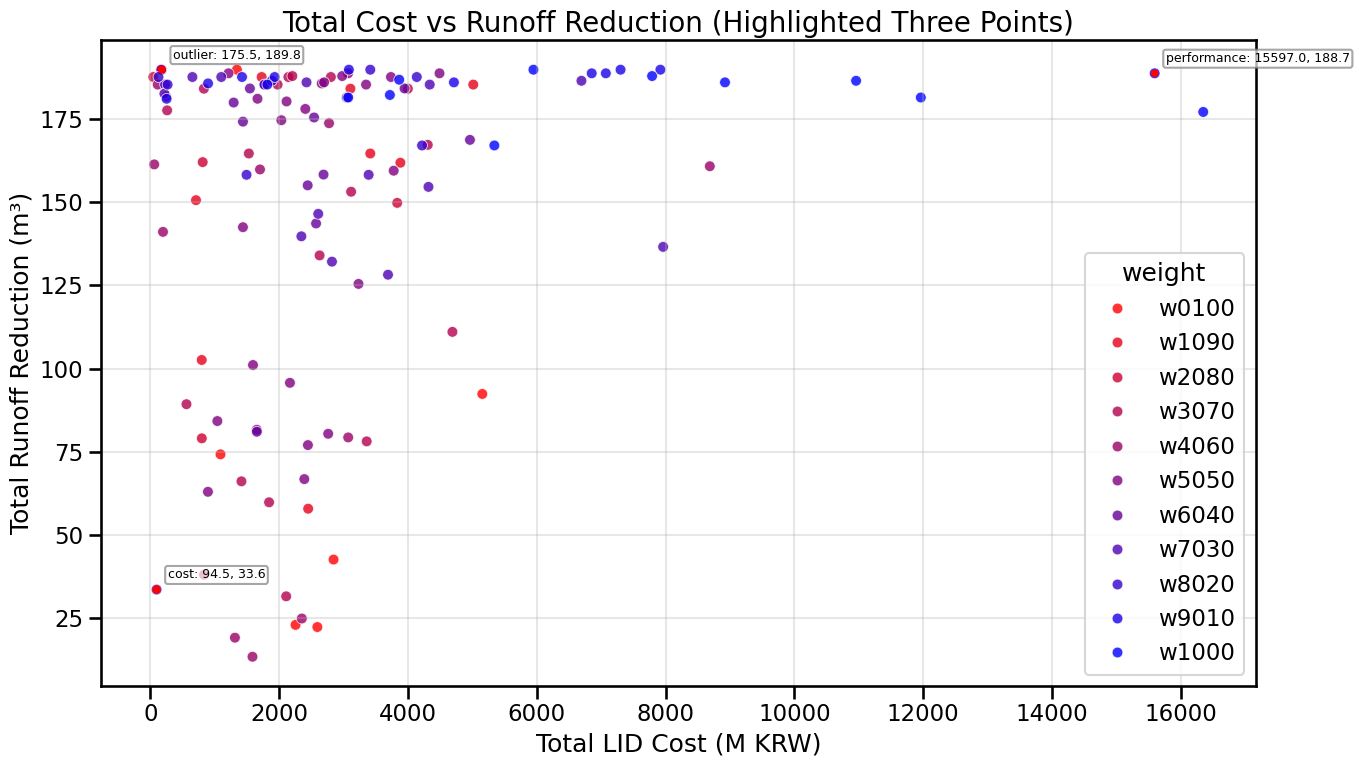

✅ 저장: scatter_all_annotated_from_nb.png


In [ ]:
# 산점도 위에 세 점을 오버레이하고 저장
print("=== 세 점 산점도 오버레이 ===")

# 가중치 색상 팔레트 (기존 함수 사용)
weight_palette = {w: weight_color_mapping[w][:3] for w in WEIGHT_DIR}

pyplot.figure(figsize=(14, 8))
sns.scatterplot(
    data=all_lid_data,
    x='Total LID Cost (M KRW)',
    y='Total Runoff Reduction (m³)',
    hue='weight',
    palette=weight_palette,
    s=60,
    alpha=0.8
)

# 마커는 유형별로 구분, 색상은 '가중치 팔레트(저비용=빨강, 고성능=파랑)' 적용
marker_map = {'outlier': '*', 'performance': '^', 'cost': 's'}
size_map = {'outlier': 300, 'performance': 250, 'cost': 220}

for ptype in ['outlier', 'performance', 'cost']:
    if ptype in selected_points_nb:
        p = selected_points_nb[ptype]
        x = float(p['Total LID Cost (M KRW)'])
        y = float(p['Total Runoff Reduction (m³)'])
        w = p['weight']
        color = weight_color_mapping.get(w, (0.3, 0.3, 0.3, 1.0))[:3]
        pyplot.scatter([x], [y],
                   facecolors='none',
                   edgecolors='red',
                   s=10,
                   linewidths=2.5)
        pyplot.annotate(f"{ptype}: {x:.1f}, {y:.1f}", (x, y), textcoords='offset points', xytext=(8, 8),
                        fontsize=9, color='black', bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='gray', alpha=0.7))

pyplot.title('Total Cost vs Runoff Reduction (Highlighted Three Points)', fontsize=20)
pyplot.xlabel('Total LID Cost (M KRW)')
pyplot.ylabel('Total Runoff Reduction (m³)')
# pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
pyplot.grid(True, alpha=0.3)
pyplot.tight_layout()
output_path = 'scatter_all_annotated_from_nb.png'
pyplot.savefig(output_path, dpi=200)
pyplot.show()

print(f'✅ 저장: {output_path}')


In [ ]:
# 세 점의 LID 구성 데이터 추출 (파일 탐색 + 시트/컬럼 자동 인식)
print("=== 세 점 LID 구성 추출 ===")

from typing import Optional, Tuple

def find_batch_file_for_point(base_dir: str, point_row) -> Optional[str]:
    weight = point_row['weight']
    cost = float(point_row['Total LID Cost (M KRW)'])
    perf = float(point_row['Total Runoff Reduction (m³)'])
    weight_path = os.path.join(base_dir, weight, WELL_REWARDED_DIR)
    if not os.path.isdir(weight_path):
        return None
    batch_dirs = [d for d in os.listdir(weight_path) if os.path.isdir(os.path.join(weight_path, d)) and d.startswith('_batch_')]
    for batch in batch_dirs:
        file_path = os.path.join(weight_path, batch, 'lid_placement_summary.xlsx')
        if not os.path.exists(file_path):
            continue
        try:
            df_summary = pd.read_excel(file_path, sheet_name='Summary', index_col=0)
            df_t = df_summary.T
            file_cost = float(df_t['Total LID Cost (M KRW)'].iloc[0])
            file_perf = float(df_t['Total Runoff Reduction (m³)'].iloc[0])
            if abs(file_cost - cost) < 1.0 and abs(file_perf - perf) < 1.0:
                return file_path
        except Exception:
            continue
    return None

import re

def read_lid_placement_sheet(file_path: str) -> Optional[pd.DataFrame]:
    try:
        xls = pd.ExcelFile(file_path)
        # 우선 lid+place 포함된 시트
        target = None
        for s in xls.sheet_names:
            key = s.lower().replace(' ', '_')
            if 'lid' in key and 'place' in key:
                target = s
                break
        if target is None:
            # 후보 이름
            for cand in ['LID_Placements', 'LID Placement', 'LID_Placement', 'Placement', 'LID']:
                if cand in xls.sheet_names:
                    target = cand
                    break
        if target is None:
            return None
        df = pd.read_excel(file_path, sheet_name=target)
        # 컬럼 정규화
        def norm(s):
            return re.sub(r'[^a-z0-9]', '', str(s).lower())
        colmap = {norm(c): c for c in df.columns}
        def pick(*aliases):
            for a in aliases:
                k = norm(a)
                if k in colmap:
                    return colmap[k]
                for nk, orig in colmap.items():
                    if k in nk:
                        return orig
            return None
        col_type = pick('LID_Type', 'LID Type', 'Type')
        col_area = pick('Area_m2', 'Total Area', 'Area', 'Area (m2)')
        col_pct = pick('Area_Percentage_of_Subcatchment', 'Area %', 'Percentage')
        # area 우선, 없으면 pct 사용
        if col_type is None:
            return None
        if col_area is None and col_pct is None:
            return None
        value_col = col_area if col_area is not None else col_pct
        out = df[[col_type, value_col]].copy()
        out.columns = ['LID_Type', 'Value']
        out = out[out['LID_Type'].astype(str).str.upper() != 'TOTAL']
        return out
    except Exception:
        return None

selected_points_details = {}
for ptype in ['outlier', 'performance', 'cost']:
    if ptype in selected_points_nb:
        row = selected_points_nb[ptype]
        f = find_batch_file_for_point(BASE_DIR, row)
        comp = read_lid_placement_sheet(f) if f else None
        selected_points_details[ptype] = {'row': row, 'file': f, 'composition': comp}
        print(f"{ptype}: file={'FOUND' if f else 'NOT FOUND'}, comp_rows={len(comp) if comp is not None else 0}")


=== 세 점 LID 구성 추출 ===
outlier: file=FOUND, comp_rows=3
performance: file=FOUND, comp_rows=4
cost: file=FOUND, comp_rows=2


=== 세 점 개별 시각화 (리팩토링) ===
--- 1. LID 구성 비교 ---


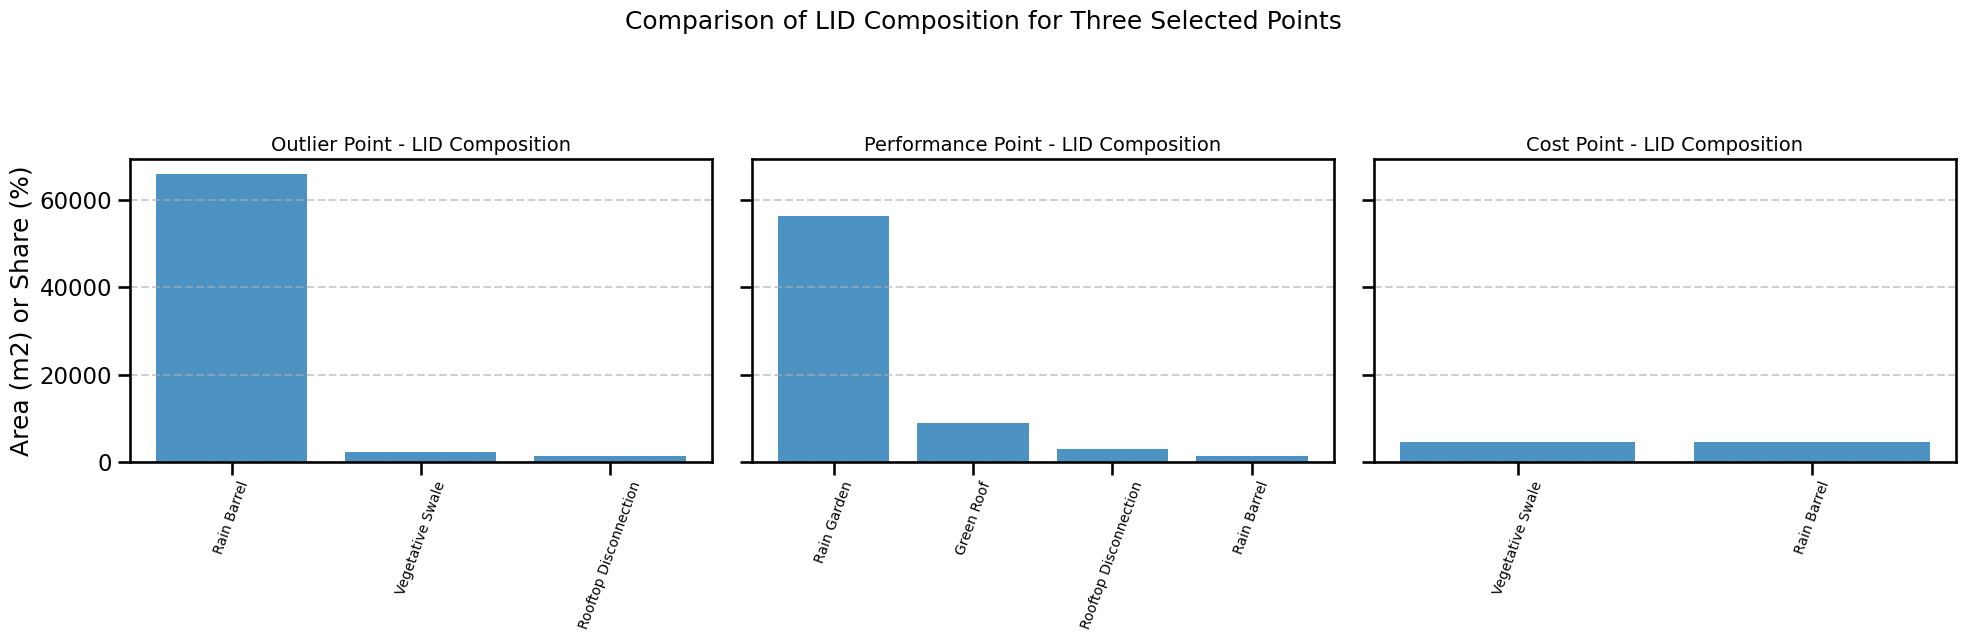

--- 2. 총 비용 비교 ---


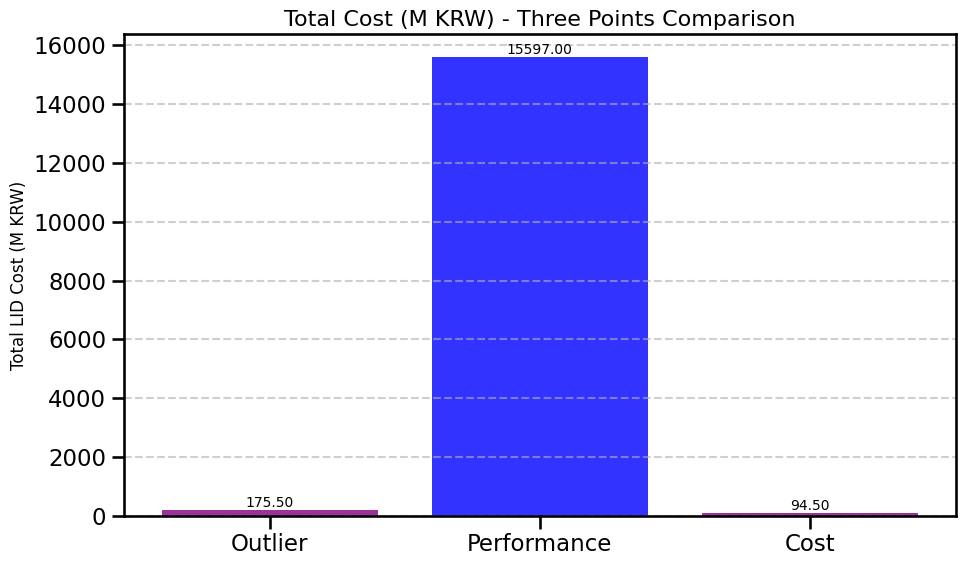

--- 3. 총 유출 저감량 비교 ---


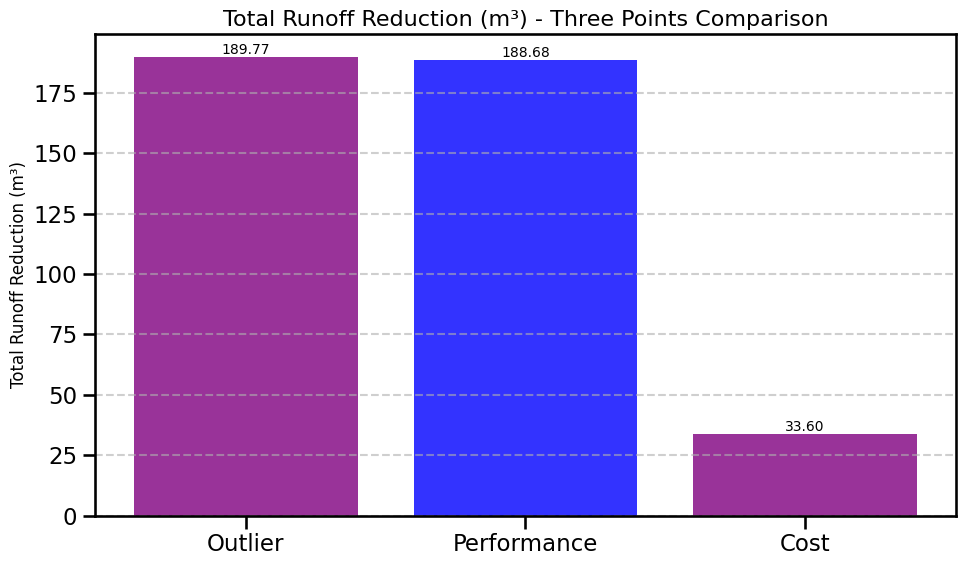

In [ ]:
# === 세 점 개별 시각화 (리팩토링) ===
print("=== 세 점 개별 시각화 (리팩토링) ===")

# --- 함수 정의 ---

def plot_lid_composition_comparison(selected_points_details, weight_color_mapping):
    """세 지점의 LID 구성을 나란히 비교하는 막대그래프를 그립니다."""
    print("--- 1. LID 구성 비교 ---")
    fig, axes = pyplot.subplots(1, 3, figsize=(20, 6), sharey=True)
    labels = ['outlier', 'performance', 'cost']

    for ax, name in zip(axes, labels):
        details = selected_points_details.get(name, {})
        comp = details.get('composition')
        
        if comp is not None and not comp.empty:
            comp = comp.sort_values(by='Value', ascending=False)
            ax.bar(comp['LID_Type'], comp['Value'], color='tab:blue', alpha=0.8)
            ax.set_title(f"{name.title()} Point - LID Composition", fontsize=14)
            ax.tick_params(axis='x', rotation=70, labelsize=10)
            ax.grid(True, axis='y', linestyle='--', alpha=0.6)
        else:
            ax.set_title(f"{name.title()} Point - No LID Data", fontsize=14)
            ax.axis('off')

    axes[0].set_ylabel("Area (m2) or Share (%)")
    fig.suptitle('Comparison of LID Composition for Three Selected Points', fontsize=18, y=1.08)
    pyplot.tight_layout()
    pyplot.show()

def plot_cost_comparison(selected_points_details, weight_color_mapping):
    """세 지점의 총 비용을 비교하는 막대그래프를 그립니다."""
    print("--- 2. 총 비용 비교 ---")
    bar_names, bar_vals, bar_colors = [], [], []
    labels = ['outlier', 'performance', 'cost']

    for name in labels:
        if name in selected_points_details:
            r = selected_points_details[name]['row']
            bar_names.append(name.title())
            bar_vals.append(float(r['Total LID Cost (M KRW)']))
            w = r['weight']
            bar_colors.append(weight_color_mapping.get(w, (0.3, 0.3, 0.3, 1.0))[:3])

    if bar_names:
        pyplot.figure(figsize=(10, 6))
        bars = pyplot.bar(bar_names, bar_vals, color=bar_colors, alpha=0.8)
        pyplot.title('Total Cost (M KRW) - Three Points Comparison', fontsize=16)
        pyplot.ylabel('Total LID Cost (M KRW)', fontsize=12)
        pyplot.grid(True, axis='y', linestyle='--', alpha=0.6)
        
        for bar in bars:
            yval = bar.get_height()
            pyplot.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=10)
            
        pyplot.tight_layout()
        pyplot.show()
    else:
        print("비교할 비용 데이터가 없습니다.")

def plot_runoff_comparison(selected_points_details, weight_color_mapping):
    """세 지점의 총 유출 저감량을 비교하는 막대그래프를 그립니다."""
    print("--- 3. 총 유출 저감량 비교 ---")
    bar_names, bar_vals, bar_colors = [], [], []
    labels = ['outlier', 'performance', 'cost']

    for name in labels:
        if name in selected_points_details:
            r = selected_points_details[name]['row']
            bar_names.append(name.title())
            bar_vals.append(float(r['Total Runoff Reduction (m³)']))
            w = r['weight']
            bar_colors.append(weight_color_mapping.get(w, (0.3, 0.3, 0.3, 1.0))[:3])

    if bar_names:
        pyplot.figure(figsize=(10, 6))
        bars = pyplot.bar(bar_names, bar_vals, color=bar_colors, alpha=0.8)
        pyplot.title('Total Runoff Reduction (m³) - Three Points Comparison', fontsize=16)
        pyplot.ylabel('Total Runoff Reduction (m³)', fontsize=12)
        pyplot.grid(True, axis='y', linestyle='--', alpha=0.6)

        for bar in bars:
            yval = bar.get_height()
            pyplot.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=10)

        pyplot.tight_layout()
        pyplot.show()
    else:
        print("비교할 유출 저감량 데이터가 없습니다.")

# --- 함수 실행 ---
# 각 함수를 호출하여 개별 그래프를 생성합니다.
if 'selected_points_details' in locals() and selected_points_details:
    plot_lid_composition_comparison(selected_points_details, weight_color_mapping)
    plot_cost_comparison(selected_points_details, weight_color_mapping)
    plot_runoff_comparison(selected_points_details, weight_color_mapping)
else:
    print("그래프를 그릴 데이터가 준비되지 않았습니다. 이전 셀들을 먼저 실행해주세요.")
 

In [ ]:
"""
세 점의 Raw 데이터 찾기
- 좌상단 점 (이상점): 저비용 고성능
- 우상단 점 (성능점): 고비용 고성능  
- 좌하단 점 (비용점): 저비용 저성능
"""


'\n세 점의 Raw 데이터 찾기\n- 좌상단 점 (이상점): 저비용 고성능\n- 우상단 점 (성능점): 고비용 고성능  \n- 좌하단 점 (비용점): 저비용 저성능\n'

In [ ]:
# 선택된 세 점의 배치 파일에서 LID 구성 데이터 추출
print("=== 세 점 LID 구성 데이터 추출 ===")

def _find_batch_info_notebook(target_point):
    weight = target_point['weight']
    cost = float(target_point['Total LID Cost (M KRW)'])
    perf = float(target_point['Total Runoff Reduction (m³)'])
    base = BASE_DIR
    weight_path = os.path.join(base, weight, WELL_REWARDED_DIR)
    if not os.path.isdir(weight_path):
        return None
    for d in os.listdir(weight_path):
        if not d.startswith('_batch_'):
            continue
        fpath = os.path.join(weight_path, d, 'lid_placement_summary.xlsx')
        if not os.path.exists(fpath):
            continue
        try:
            df_sum = pd.read_excel(fpath, sheet_name='Summary', index_col=0).T
            file_cost = float(df_sum['Total LID Cost (M KRW)'].iloc[0])
            file_perf = float(df_sum['Total Runoff Reduction (m³)'].iloc[0])
            if abs(file_cost - cost) < 1.0 and abs(file_perf - perf) < 1.0:
                return fpath
        except Exception:
            continue
    return None

def _extract_lid_table(file_path):
    # 다양한 시트/컬럼명 대응
    xls = pd.ExcelFile(file_path)
    target_sheet = None
    for name in xls.sheet_names:
        ln = name.lower().replace(' ', '_')
        if 'lid' in ln and ('place' in ln or 'placements' in ln):
            target_sheet = name
            break
    if target_sheet is None:
        # fallback
        target_sheet = 'LID_Placements'
    df = pd.read_excel(file_path, sheet_name=target_sheet)
    # 컬럼명 정규화
    def _norm(s):
        return re.sub(r'[^a-z0-9]', '', str(s).lower())
    cols = { _norm(c): c for c in df.columns }
    def _get(*names):
        for n in names:
            key = _norm(n)
            if key in cols:
                return cols[key]
            for k, orig in cols.items():
                if key in k:
                    return orig
        return None
    col_type = _get('LID_Type','LID Type','Type')
    col_area = _get('Area_m2','Total Area','Area')
    # TOTAL 행 제거
    if col_type and col_type in df.columns:
        df = df[df[col_type].astype(str).str.upper() != 'TOTAL']
    return df[[c for c in [col_type, col_area] if c is not None]].rename(columns={col_type:'LID_Type', col_area:'Area_m2'})

# 세 점의 LID 테이블 수집
lid_tables = {}
for name in ['outlier','performance','cost']:
    if name in selected_points_nb:
        fp = _find_batch_info_notebook(selected_points_nb[name])
        if fp:
            lid_tables[name] = _extract_lid_table(fp)
            print(f"{name}: {fp} ({len(lid_tables[name])} rows)")
        else:
            print(f"{name}: 배치 파일을 찾지 못함")


=== 세 점 LID 구성 데이터 추출 ===
outlier: ./results\w5050\well_rewarded\_batch_800_50_20250822_165803w5050_seed4_8lids_newcosts_643216\lid_placement_summary.xlsx (3 rows)
performance: ./results\w1000\well_rewarded\_batch_800_50_20251002_190041w1000_seed9_8lids_newcosts_643216\lid_placement_summary.xlsx (4 rows)
cost: ./results\w5050\well_rewarded\_batch_800_50_20250822_195157w5050_seed8_8lids_newcosts_643216\lid_placement_summary.xlsx (2 rows)


# LID Percentage

In [ ]:
def get_lid_percentage_data(BASE_DIR, WEIGHT_DIR, WELL_REWARDED_DIR):
    all_lid_data = []
    for weight in WEIGHT_DIR:
        weight_path = os.path.join(BASE_DIR, weight)
        well_rewarded_path = os.path.join(weight_path, WELL_REWARDED_DIR)
        
        if not os.path.isdir(well_rewarded_path):
            continue
            
        batch_dirs = [d for d in os.listdir(well_rewarded_path) if os.path.isdir(os.path.join(well_rewarded_path, d)) and d.startswith('_batch_')]
        
        for batch in batch_dirs:
            file_path = os.path.join(well_rewarded_path, batch, 'lid_placement_summary.xlsx')
            if os.path.exists(file_path):
                try:
                    # Read the first sheet which contains LID breakdown
                    df_lid = pd.read_excel(file_path)
                    
                    # Filter out the 'TOTAL' row
                    df_lid = df_lid[df_lid['LID_Type'] != 'TOTAL']
                    
                    # Add a weight column
                    df_lid['weight'] = weight
                    
                    all_lid_data.append(df_lid)
                except Exception as e:
                    print(f"Error reading or processing {file_path}: {e}")
    
    if not all_lid_data:
        return pd.DataFrame()
        
    # Concatenate all dataframes
    full_lid_df = pd.concat(all_lid_data, ignore_index=True)
    
    # Aggregate the data: calculate the average percentage for each LID type within each weight
    lid_pivot = full_lid_df.pivot_table(
        index='weight', 
        columns='LID_Type', 
        values='Area_Percentage_of_Subcatchment', 
        aggfunc='mean'
    )
    
    # Fill NaN values with 0
    lid_pivot = lid_pivot.fillna(0)
    return lid_pivot

In [ ]:
# Get the processed data
lid_percentage_data = get_lid_percentage_data(BASE_DIR, WEIGHT_DIR, WELL_REWARDED_DIR)
print(lid_percentage_data)

LID_Type  Bio-Retention Cell  Green Roof  Infiltration Trench  \
weight                                                          
w0100              10.000000    9.125000             2.250000   
w1000              13.900000   14.750000             9.750000   
w1090               8.500000   19.700000             6.000000   
w2080               2.750000    1.000000            10.000000   
w3070               4.833333    9.625000             2.750000   
w4060              13.333333   32.500000             4.333333   
w5050               4.545455   16.906250             2.125000   
w6040               7.214286    6.071429             2.500000   
w7030               8.642857   12.350000             3.571429   
w8020               2.125000   11.333333             4.250000   
w9010               3.900000   12.937500             5.800000   

LID_Type  Permeable Pavement  Rain Barrel  Rain Garden  Rooftop Disconnection  \
weight                                                                   

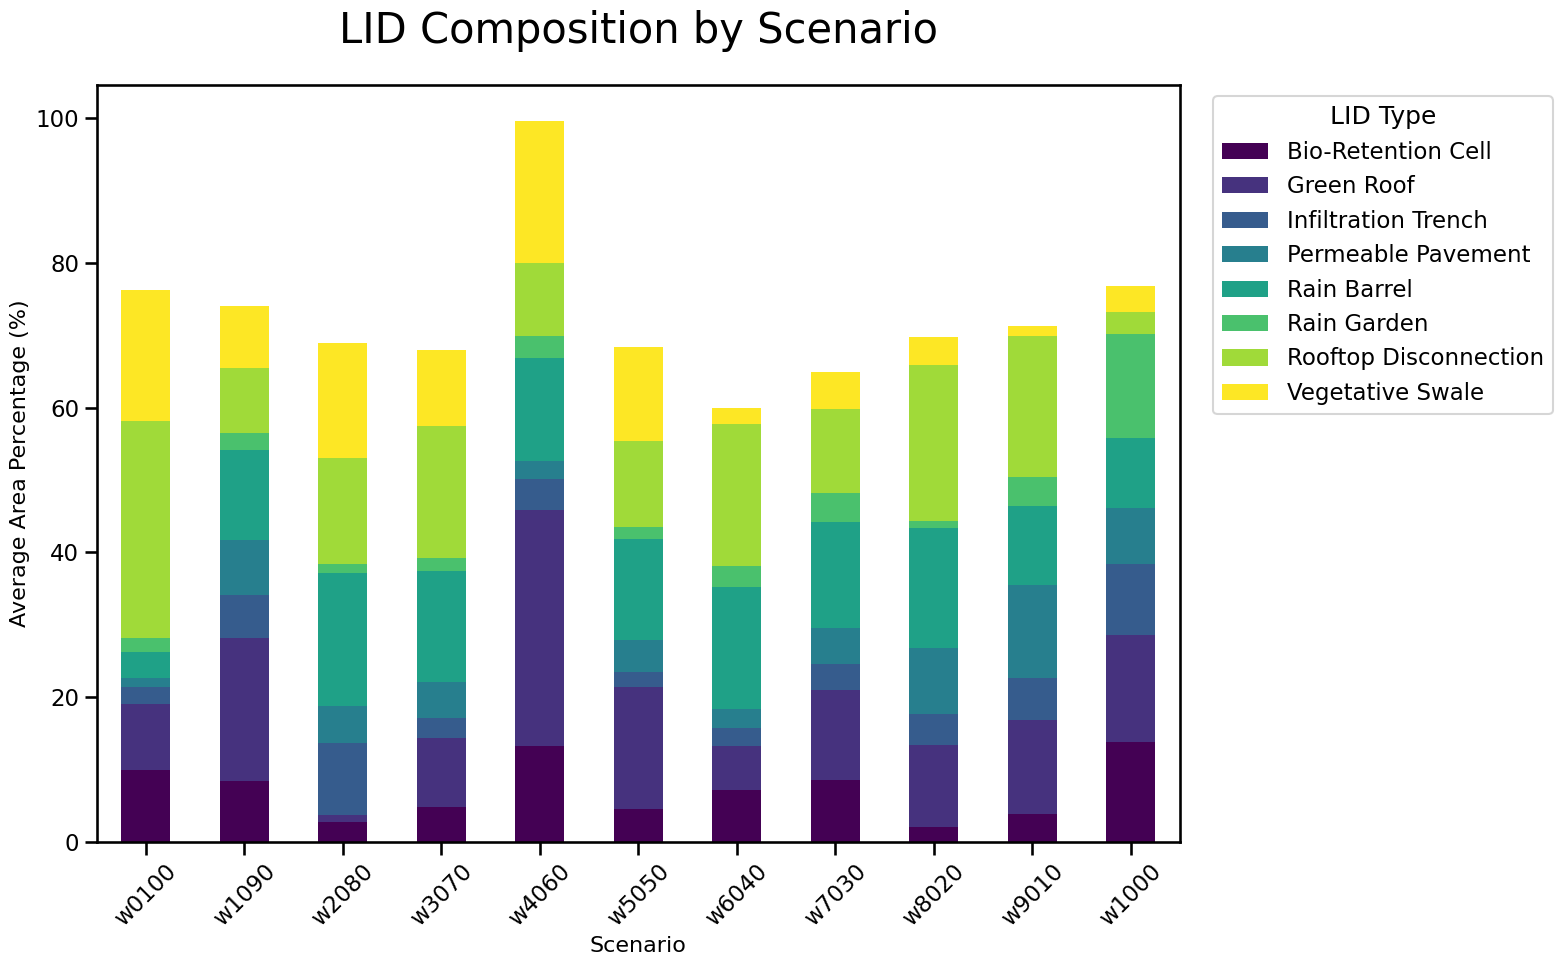

In [ ]:
# Plotting the stacked bar chart
sns.set_context("talk") # Increase font sizes for better readability

# Reorder the dataframe to match the desired WEIGHT_DIR order
lid_percentage_data = lid_percentage_data.reindex(WEIGHT_DIR)

ax = lid_percentage_data.plot(
    kind='bar', 
    stacked=True, 
    figsize=(16, 10),
    colormap='viridis'
)

# Set titles and labels
ax.set_title('LID Composition by Scenario', fontsize=30, pad=30)
ax.set_xlabel('Scenario', fontsize=16)
ax.set_ylabel('Average Area Percentage (%)', fontsize=16)

# Rotate x-axis labels for better visibility
pyplot.xticks(rotation=45)

# Adjust legend
ax.legend(title='LID Type', bbox_to_anchor=(1.02, 1), loc='upper left')

pyplot.tight_layout()
pyplot.show()


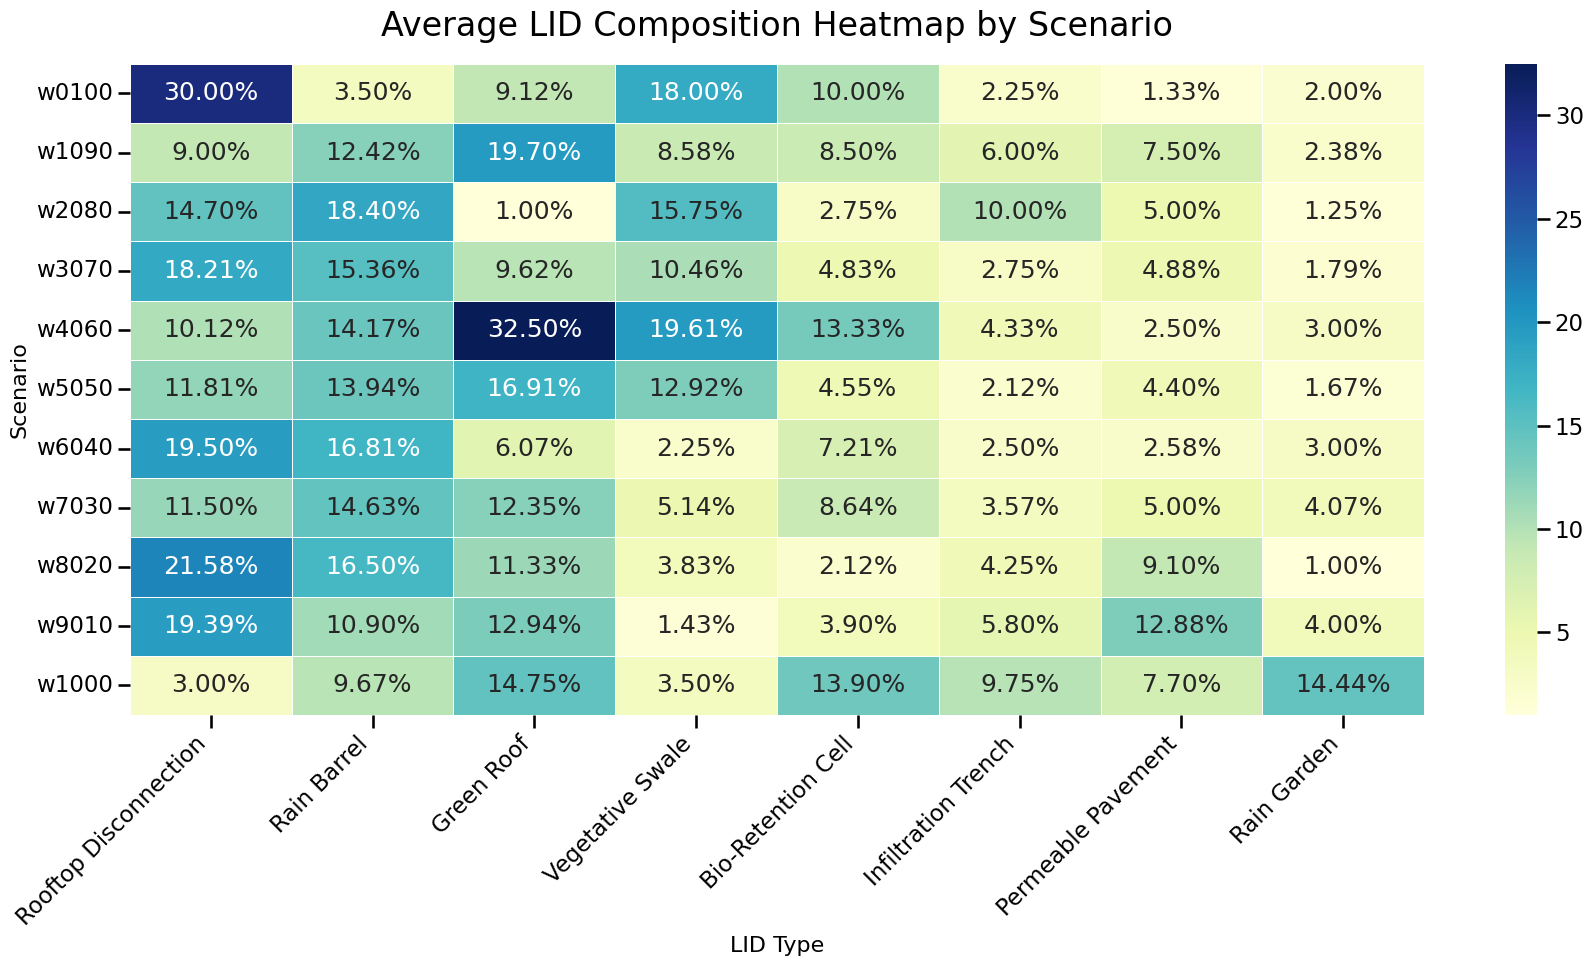

In [ ]:
# Create a heatmap from the data
pyplot.figure(figsize=(18, 10))
sns.set_context("talk")
lid_type_order = ['Rooftop Disconnection', 'Rain Barrel', 'Green Roof', 'Vegetative Swale', 'Bio-Retention Cell', 'Infiltration Trench', 'Permeable Pavement', 'Rain Garden']
# Reorder the dataframe to match the desired WEIGHT_DIR order
lid_percentage_data_ordered = lid_percentage_data.reindex(WEIGHT_DIR)
lid_percentage_data_ordered = lid_percentage_data_ordered.reindex(columns=lid_type_order, fill_value=0)

annot_df = lid_percentage_data_ordered.apply(lambda x: x.apply(lambda y: f'{y:.2f}%'))
sns.heatmap(
    lid_percentage_data_ordered,
    annot=annot_df,          # Annotate cells with values
    fmt="",           # Format annotations to two decimal places
    cmap='YlGnBu',       # Use a sequential colormap
    linewidths=.5        # Add lines between cells
)

# Set titles and labels
pyplot.title('Average LID Composition Heatmap by Scenario', fontsize=24, pad=20)
pyplot.xlabel('LID Type', fontsize=16)
pyplot.ylabel('Scenario', fontsize=16)
pyplot.xticks(rotation=45, ha='right') # Rotate labels for better readability
pyplot.yticks(rotation=0)

pyplot.tight_layout()
pyplot.show()


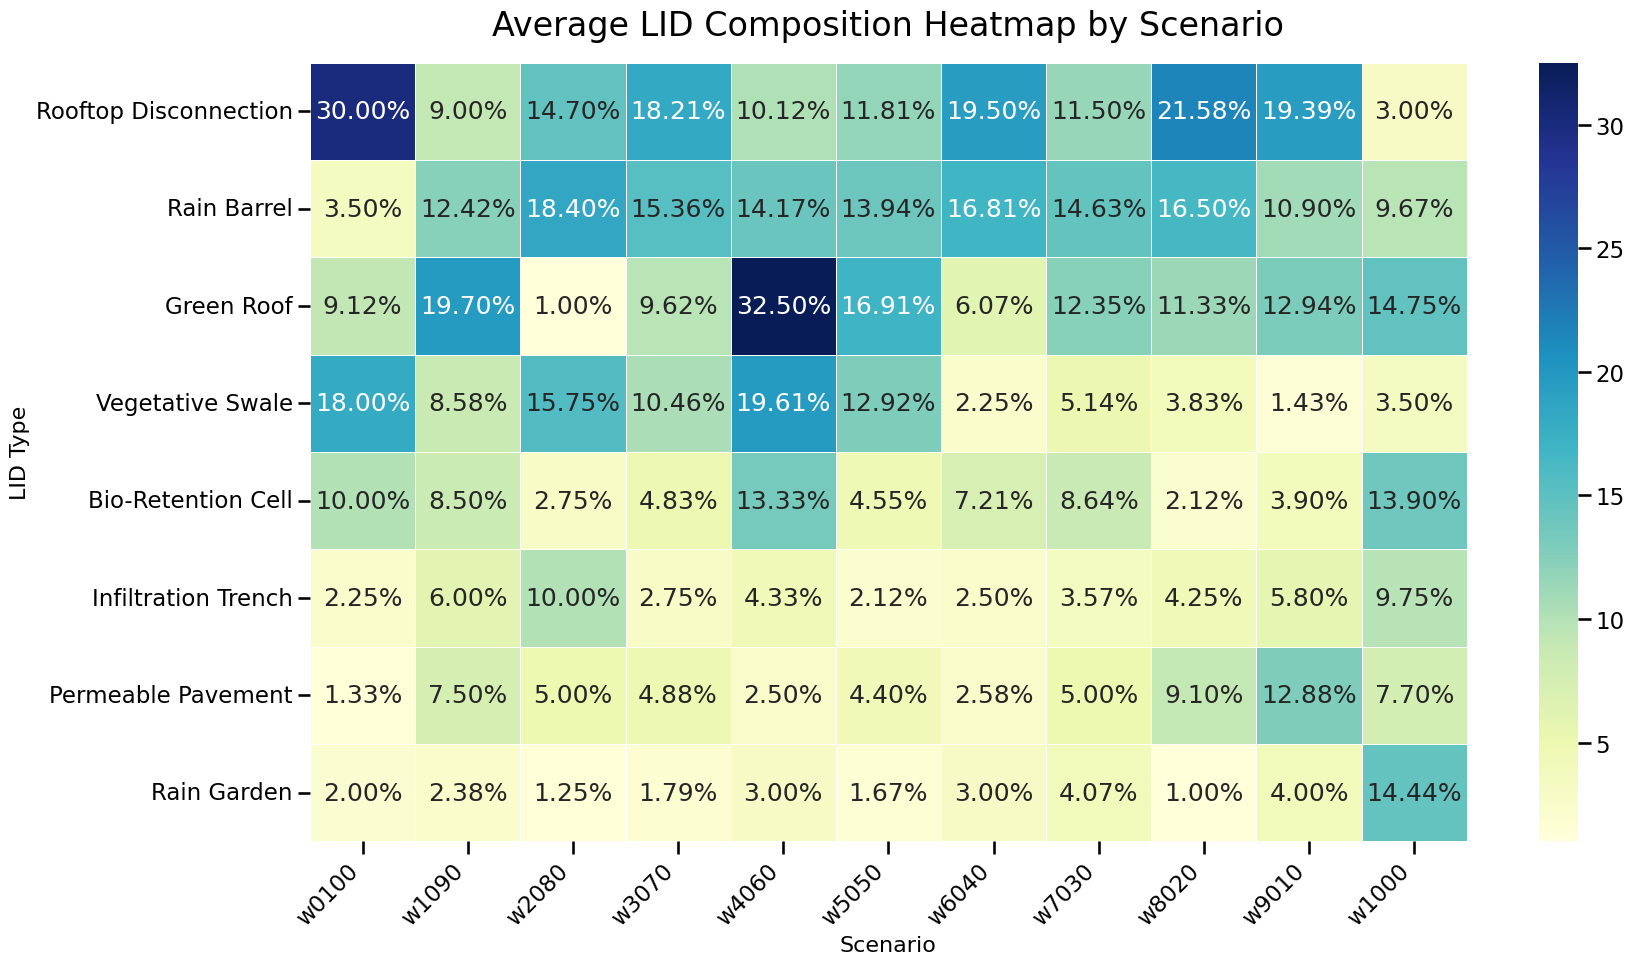

In [ ]:
# Create a heatmap from the data
pyplot.figure(figsize=(18, 10))
sns.set_context("talk")
lid_type_order = ['Rooftop Disconnection', 'Rain Barrel', 'Green Roof', 'Vegetative Swale', 'Bio-Retention Cell', 'Infiltration Trench', 'Permeable Pavement', 'Rain Garden']
# Reorder the dataframe to match the desired WEIGHT_DIR order
lid_percentage_data_ordered = lid_percentage_data.reindex(WEIGHT_DIR)
lid_percentage_data_ordered = lid_percentage_data_ordered.reindex(columns=lid_type_order, fill_value=0)

annot_df = lid_percentage_data_ordered.apply(lambda x: x.apply(lambda y: f'{y:.2f}%')).T
sns.heatmap(
    lid_percentage_data_ordered.T,
    annot=annot_df,          # Annotate cells with values
    fmt="",           # Format annotations to two decimal places
    cmap='YlGnBu',       # Use a sequential colormap
    linewidths=.5        # Add lines between cells
)

# Set titles and labels
pyplot.title('Average LID Composition Heatmap by Scenario', fontsize=24, pad=20)
pyplot.xlabel('Scenario', fontsize=16)
pyplot.ylabel('LID Type', fontsize=16)
pyplot.xticks(rotation=45, ha='right') # Rotate labels for better readability
pyplot.yticks(rotation=0)

pyplot.tight_layout()
pyplot.show()

In [ ]:
# --- 가중치별 요약 통계 생성 ---
 # 1. 평균 비용 및 평균 유출 저감량 계산
 #    기존에 로드된 all_lid_data를 사용합니다.
summary_cost_runoff = all_lid_data.groupby('weight')[[
    'Total LID Cost (M KRW)',
    'Total Runoff Reduction (m³)'
]].mean()
# 2. 평균 총 LID 면적 계산을 위한 함수 정의
def get_average_area_data(base_dir, weight_folders, well_rewarded_dir):
    area_data = []
    for weight in weight_folders:
        weight_path = os.path.join(base_dir, weight, well_rewarded_dir)
        search_pattern = os.path.join(weight_path, '_batch_*', 'lid_placement_summary.xlsx')
        file_paths = glob.glob(search_pattern)
        for file_path in file_paths:
            try:
                # 'LID_Placements' 시트에서 'TOTAL' 행의 'Area_m2' 값을 직접 읽어옵니다.
                df_placements = pd.read_excel(file_path, sheet_name='LID_Placements')
                total_area_row = df_placements[df_placements['LID_Type'] == 'TOTAL']
                if not total_area_row.empty:
                    total_area = total_area_row['Area_m2'].iloc[0]
                    area_data.append({'weight': weight, 'Total Area (m2)': total_area})
            except Exception as e:
                # 'LID_Placements' 시트가 없는 구버전 결과 파일일 수 있으므로, Summary 시트에서합계를 계산합니다.
                try:
                    df_summary = pd.read_excel(file_path, sheet_name='Summary', index_col=0).T
                    total_area = df_summary['Total LID Area (m2)'].iloc[0]
                    area_data.append({'weight': weight, 'Total Area (m2)': total_area})
                except Exception as e_inner:
                    print(f"Error processing area from {file_path}: {e_inner}")
    if not area_data:
        return pd.DataFrame()
    df_area = pd.DataFrame(area_data)
    return df_area.groupby('weight')[['Total Area (m2)']].mean()
# 3. 평균 면적 데이터 가져오기
summary_area = get_average_area_data(BASE_DIR, WEIGHT_DIR, WELL_REWARDED_DIR)
# 4. 데이터 병합
#    비용/유출량 요약과 면적 요약을 합칩니다.
summary_df = pd.concat([summary_area, summary_cost_runoff], axis=1)
# 5. WEIGHT_DIR 순서대로 정렬
summary_df = summary_df.reindex(WEIGHT_DIR)
summary_df = summary_df.rename(columns={
    'Total Area (m2)': 'Average Total Area (m²)',
    'Total LID Cost (M KRW)': 'Average Total Cost (M KRW)',
    'Total Runoff Reduction (m³)': 'Average Runoff Reduction (m³)'
})
# 6. 결과 출력 (스타일링 포함)
print("=== 가중치별 평균 요약 (면적, 비용, 유출 저감량) ===")
display(summary_df.style.format({
    'Total Area (m2)': '{:,.2f}',
    'Total LID Cost (M KRW)': '{:,.2f}',
    'Total Runoff Reduction (m³)': '{:,.2f}'
}).background_gradient(cmap='YlGnBu'))

=== 가중치별 평균 요약 (면적, 비용, 유출 저감량) ===


,Average Total Area (m²),Average Total Cost (M KRW),Average Runoff Reduction (m³)
weight,,,
w0100,51125.000000,2545.375000,74.052925
w1090,62718.750000,2636.625000,149.300154
w2080,66900.000000,1451.775000,152.733545
w3070,61342.105263,2148.809211,135.189566
w4060,64977.272727,2264.863636,118.854972
w5050,63870.000000,2125.935000,140.550573
w6040,56550.000000,2507.437500,160.430732
w7030,65450.000000,3054.875000,165.194431
w8020,69656.250000,2163.046875,180.894029


In [ ]:
# --- 요약 통계표를 Excel 파일로 저장 ---
# 1. 저장할 파일명 지정
output_excel_path = 'summary_by_weight.xlsx'
# 2. 데이터프레임을 Excel 파일로 저장
#    index=True 옵션을 사용하여 'weight' 열을 파일에 포함시킵니다.
try:
    summary_df.to_excel(output_excel_path, index=True)
    print(f"✅ 성공: 요약 통계표가 '{output_excel_path}' 파일로 저장되었습니다.")
except Exception as e:
    print(f"❌ 오류: 파일 저장 중 문제가 발생했습니다 - {e}")

# 이 코드를 다시 실행해주세요
print("=== 가중치별 평균 요약 (면적, 비용, 유출 저감량) ===")
display(summary_df.style.format({
    'Average Total Area (m²)': '{:,.2f}',
    'Average Total Cost (M KRW)': '{:,.2f}',
    'Average Runoff Reduction (m³)': '{:,.2f}'
}).background_gradient(cmap='YlGnBu'))

✅ 성공: 요약 통계표가 'summary_by_weight.xlsx' 파일로 저장되었습니다.
=== 가중치별 평균 요약 (면적, 비용, 유출 저감량) ===


,Average Total Area (m²),Average Total Cost (M KRW),Average Runoff Reduction (m³)
weight,,,
w0100,"51,125.00","2,545.38",74.05
w1090,"62,718.75","2,636.62",149.30
w2080,"66,900.00","1,451.78",152.73
w3070,"61,342.11","2,148.81",135.19
w4060,"64,977.27","2,264.86",118.85
w5050,"63,870.00","2,125.93",140.55
w6040,"56,550.00","2,507.44",160.43
w7030,"65,450.00","3,054.88",165.19
w8020,"69,656.25","2,163.05",180.89


In [ ]:
lid_percentage_data

LID_Type,Bio-Retention Cell,Green Roof,Infiltration Trench,Permeable Pavement,Rain Barrel,Rain Garden,Rooftop Disconnection,Vegetative Swale
weight,,,,,,,,
w0100,10.000000,9.125000,2.250000,1.333333,3.500000,2.000000,30.000000,18.000000
w1090,8.500000,19.700000,6.000000,7.500000,12.416667,2.375000,9.000000,8.583333
w2080,2.750000,1.000000,10.000000,5.000000,18.400000,1.250000,14.700000,15.750000
w3070,4.833333,9.625000,2.750000,4.875000,15.363636,1.785714,18.208333,10.464286
w4060,13.333333,32.500000,4.333333,2.500000,14.166667,3.000000,10.125000,19.611111
w5050,4.545455,16.906250,2.125000,4.400000,13.937500,1.666667,11.805556,12.916667
w6040,7.214286,6.071429,2.500000,2.583333,16.812500,3.000000,19.500000,2.250000
w7030,8.642857,12.350000,3.571429,5.000000,14.633333,4.071429,11.500000,5.142857
w8020,2.125000,11.333333,4.250000,9.100000,16.500000,1.000000,21.583333,3.833333


In [ ]:
lid_percentage_data_ordered

LID_Type,Rooftop Disconnection,Rain Barrel,Green Roof,Vegetative Swale,Bio-Retention Cell,Infiltration Trench,Permeable Pavement,Rain Garden
weight,,,,,,,,
w0100,30.000000,3.500000,9.125000,18.000000,10.000000,2.250000,1.333333,2.000000
w1090,9.000000,12.416667,19.700000,8.583333,8.500000,6.000000,7.500000,2.375000
w2080,14.700000,18.400000,1.000000,15.750000,2.750000,10.000000,5.000000,1.250000
w3070,18.208333,15.363636,9.625000,10.464286,4.833333,2.750000,4.875000,1.785714
w4060,10.125000,14.166667,32.500000,19.611111,13.333333,4.333333,2.500000,3.000000
w5050,11.805556,13.937500,16.906250,12.916667,4.545455,2.125000,4.400000,1.666667
w6040,19.500000,16.812500,6.071429,2.250000,7.214286,2.500000,2.583333,3.000000
w7030,11.500000,14.633333,12.350000,5.142857,8.642857,3.571429,5.000000,4.071429
w8020,21.583333,16.500000,11.333333,3.833333,2.125000,4.250000,9.100000,1.000000


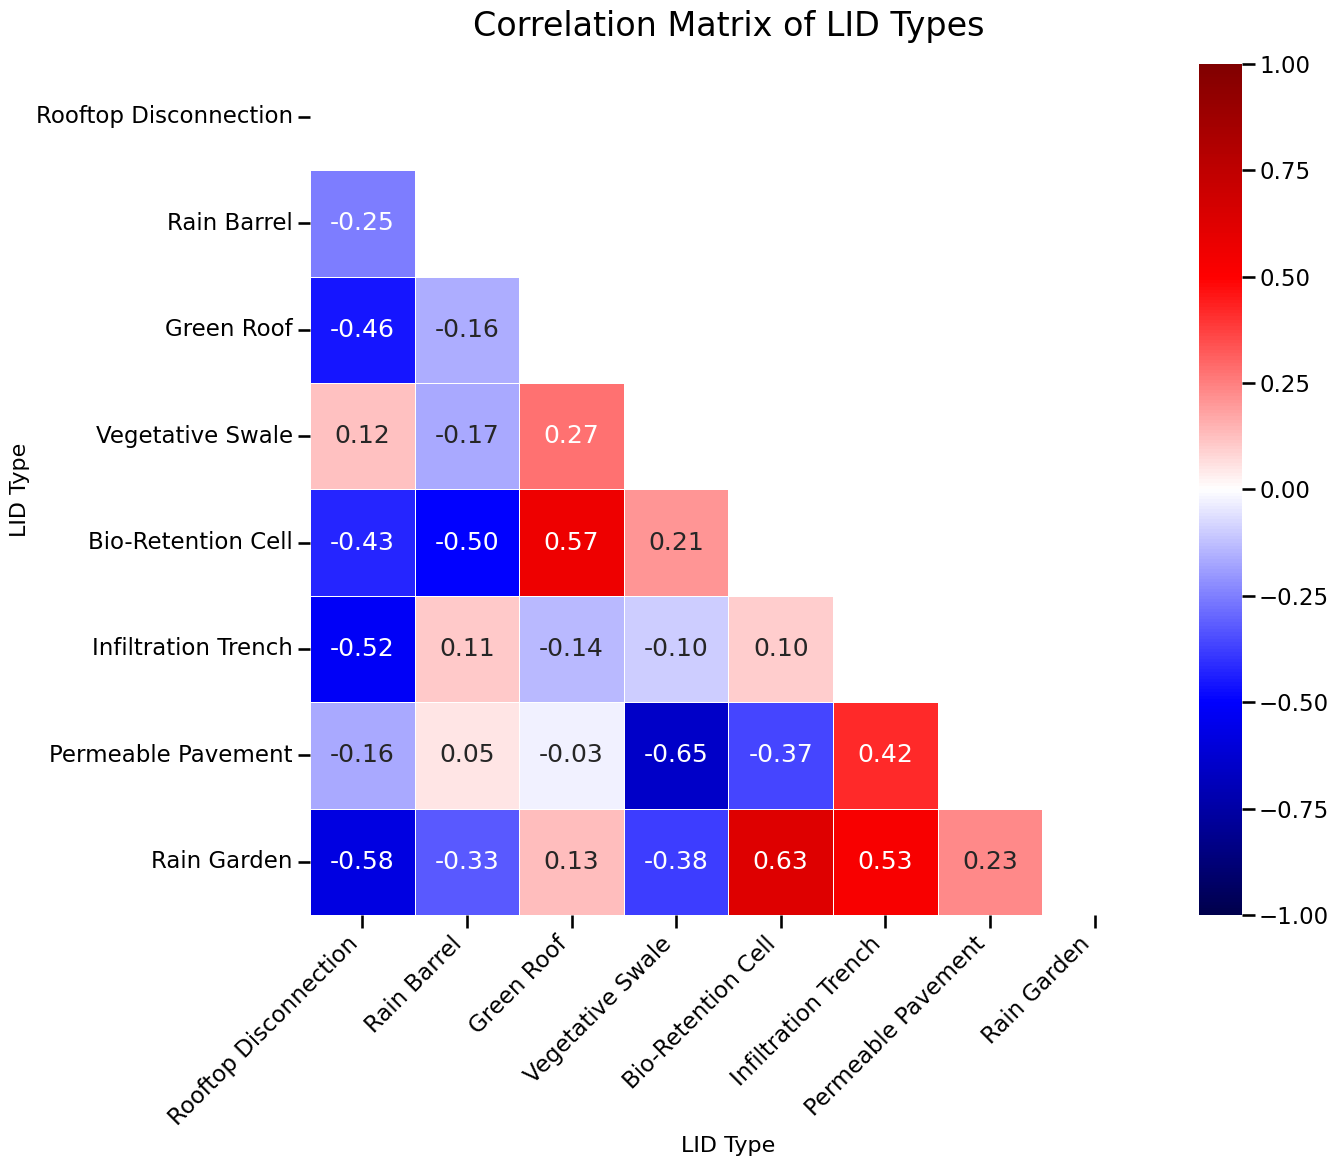

In [ ]:
# --- LID 유형 간 상관관계 분석을 위한 Heatmap ---
# 1. 상관 행렬 계산
#    각 LID 유형(열) 간의 상관관계를 계산합니다.
#    값이 1에 가까우면 함께 사용되는 경향이 강하고, -1에 가까우면 하나가 사용될 때 다른 하나는사용되지 않는 경향이 있음을 의미합니다.
correlation_matrix = lid_percentage_data_ordered.corr(method='pearson')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# 2. 상관 행렬 Heatmap 시각화
pyplot.figure(figsize=(14, 12))
sns.set_context("talk")
sns.heatmap(
    correlation_matrix,
    annot=True,                # 상관 계수를 셀에 표시
    fmt=".2f",                 # 소수점 둘째 자리까지 표시
    cmap='seismic',           # 양/음의 상관관계를 잘 보여주는 'coolwarm' 컬러맵 사용
    linewidths=.5,
    vmin=-1, vmax=1,
    mask = mask          # 색상 범위를 -1에서 1로 고정
)
# 제목 및 레이블 설정
pyplot.title('Correlation Matrix of LID Types', fontsize=24, pad=20)
pyplot.xticks(rotation=45, ha='right')
pyplot.yticks(rotation=0)
pyplot.xlabel('LID Type', fontsize=16)
pyplot.ylabel('LID Type', fontsize=16)
pyplot.tight_layout()
pyplot.show()

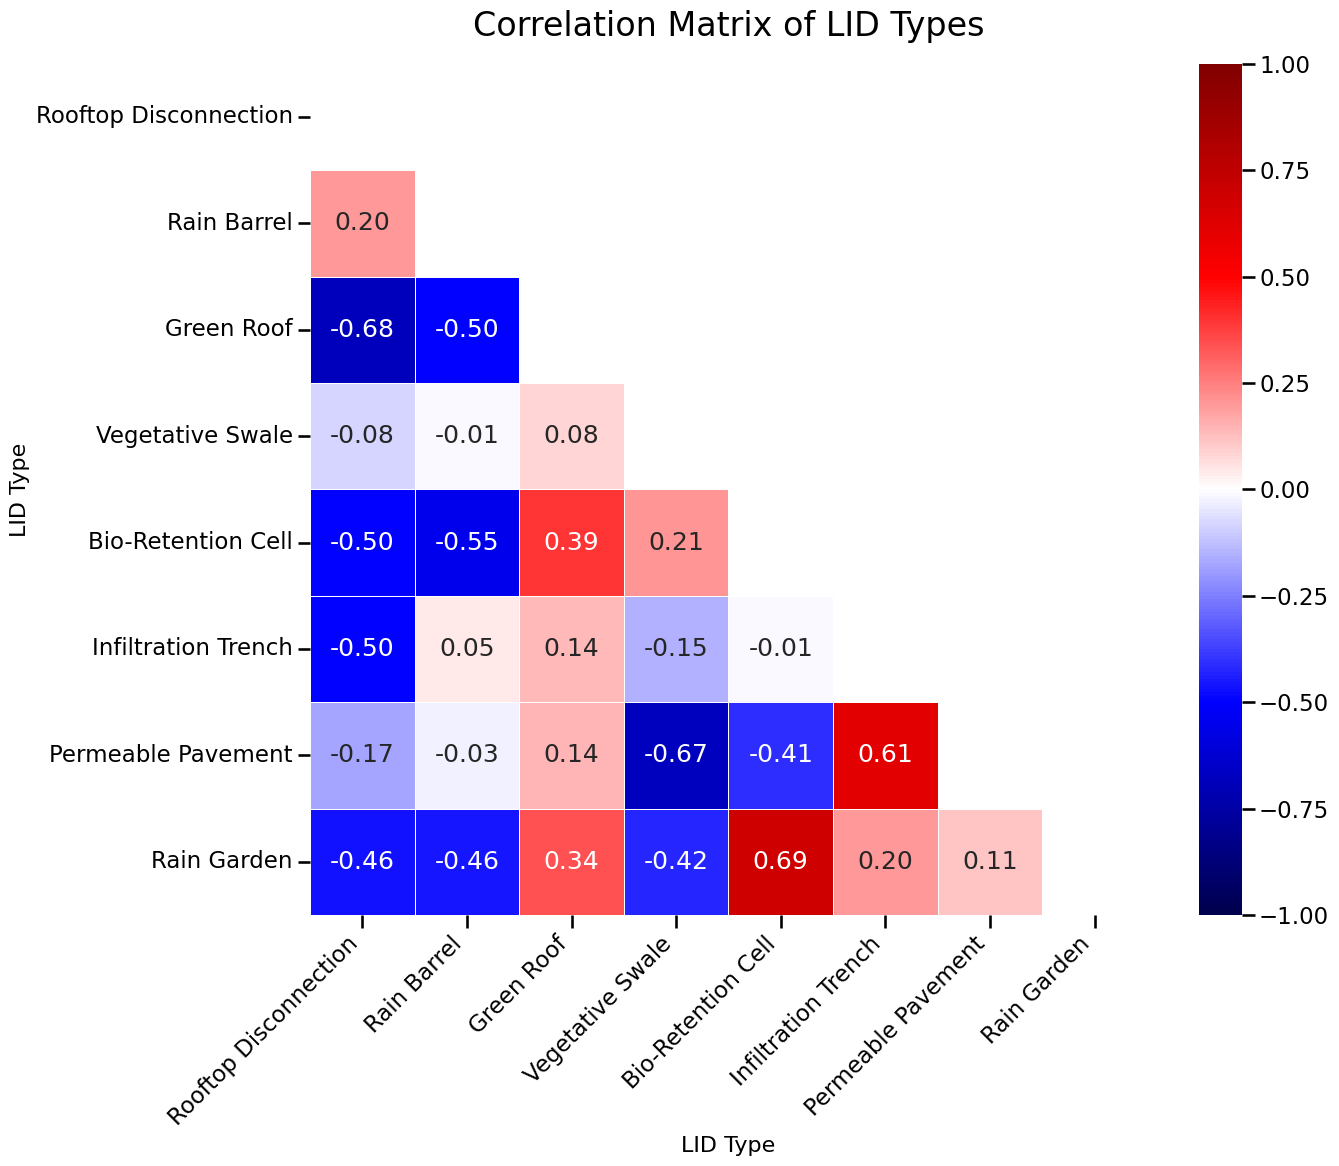

In [ ]:
# --- LID 유형 간 상관관계 분석을 위한 Heatmap ---
# 1. 상관 행렬 계산
#    각 LID 유형(열) 간의 상관관계를 계산합니다.
#    값이 1에 가까우면 함께 사용되는 경향이 강하고, -1에 가까우면 하나가 사용될 때 다른 하나는사용되지 않는 경향이 있음을 의미합니다.
correlation_matrix = lid_percentage_data_ordered.corr(method='spearman')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# 2. 상관 행렬 Heatmap 시각화
pyplot.figure(figsize=(14, 12))
sns.set_context("talk")
sns.heatmap(
    correlation_matrix,
    annot=True,                # 상관 계수를 셀에 표시
    fmt=".2f",                 # 소수점 둘째 자리까지 표시
    cmap='seismic',           # 양/음의 상관관계를 잘 보여주는 'coolwarm' 컬러맵 사용
    linewidths=.5,
    vmin=-1, vmax=1,
    mask = mask          # 색상 범위를 -1에서 1로 고정
)
# 제목 및 레이블 설정
pyplot.title('Correlation Matrix of LID Types', fontsize=24, pad=20)
pyplot.xticks(rotation=45, ha='right')
pyplot.yticks(rotation=0)
pyplot.xlabel('LID Type', fontsize=16)
pyplot.ylabel('LID Type', fontsize=16)
pyplot.tight_layout()
pyplot.show()

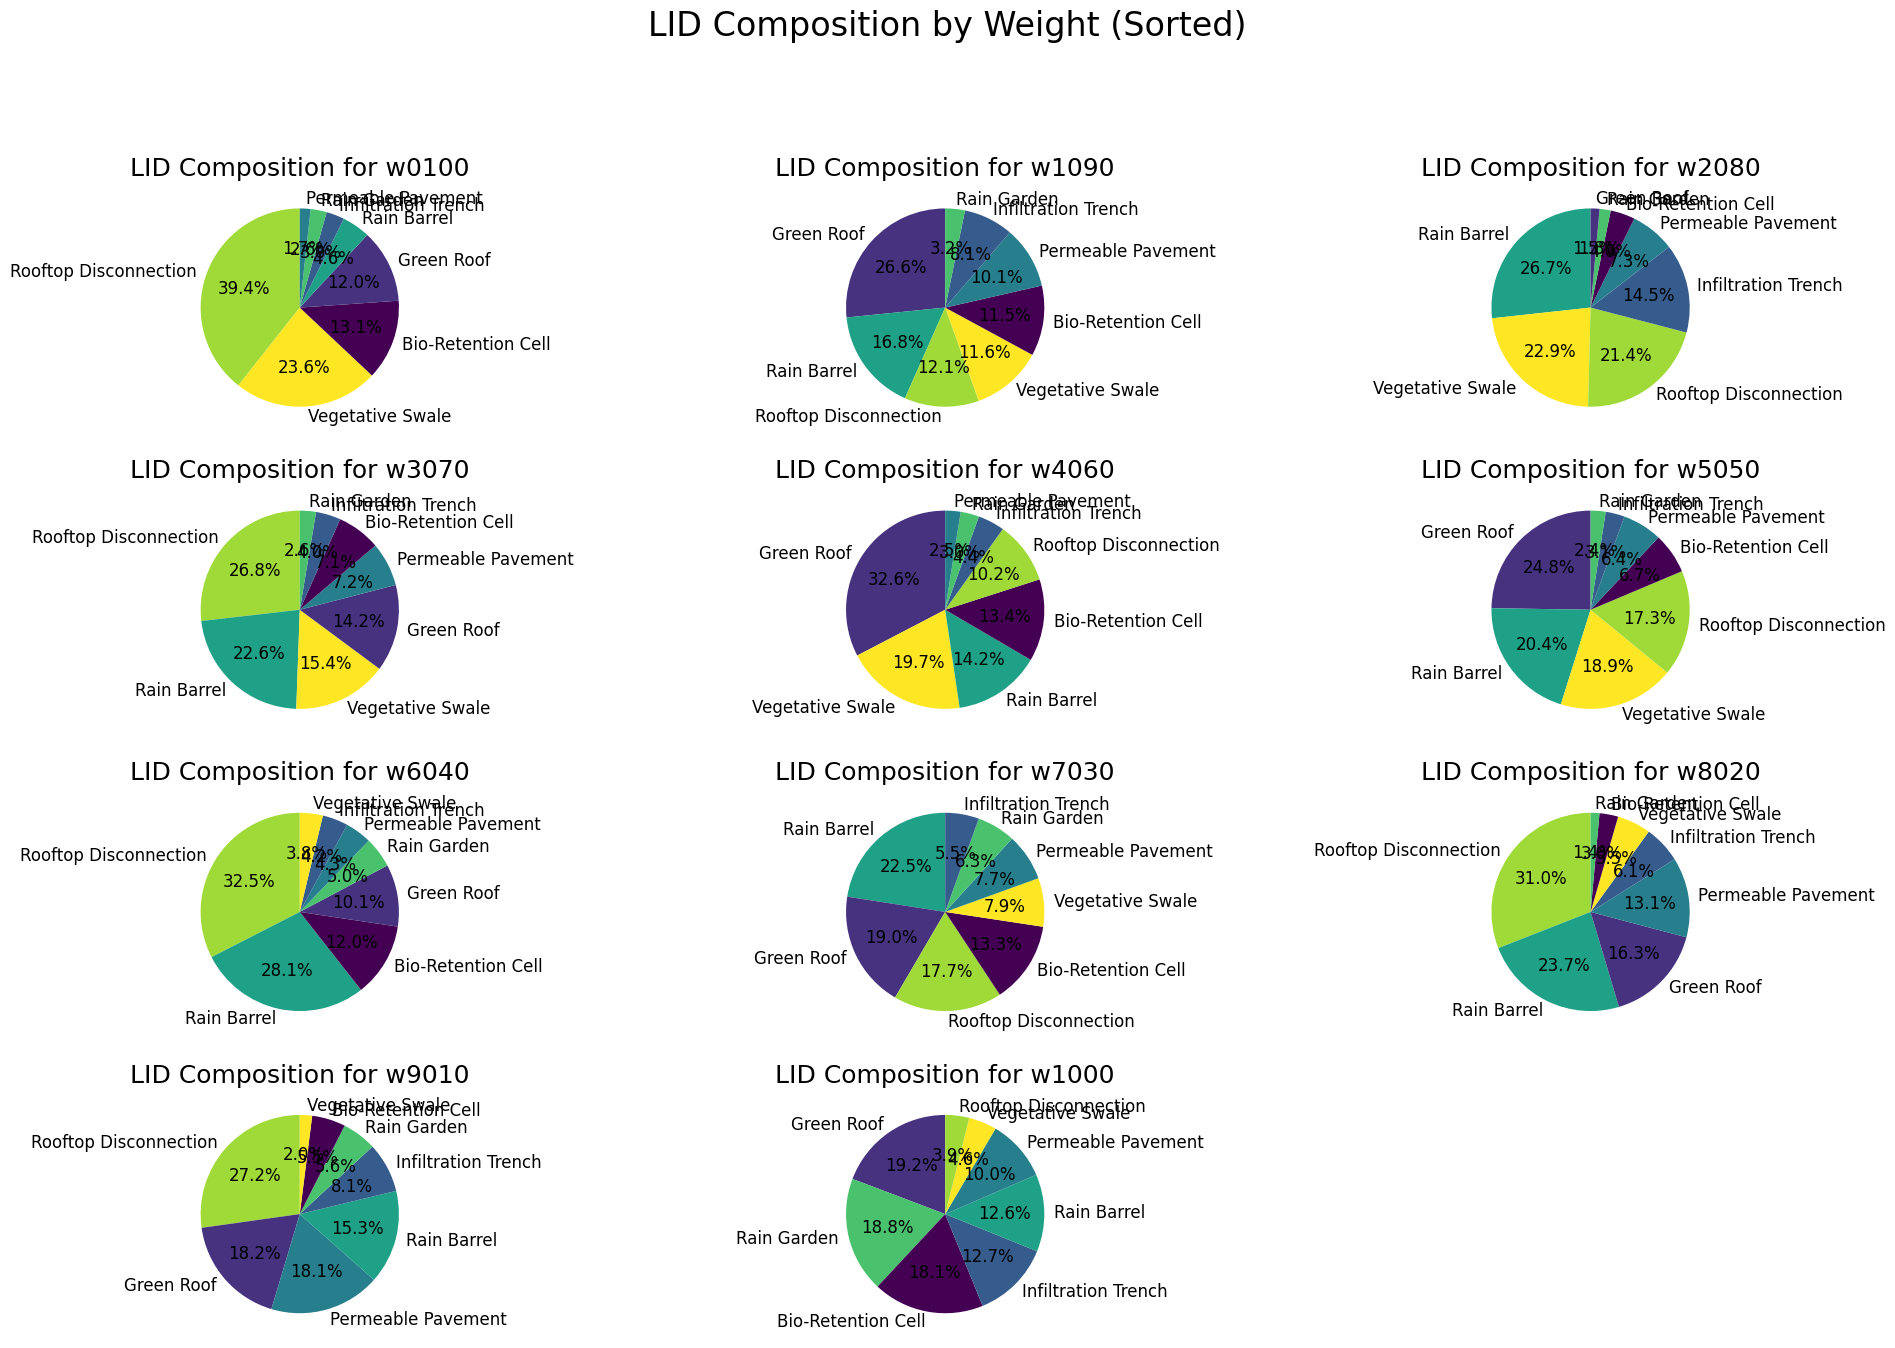

In [ ]:

# Create a grid of pie charts for each weight
fig, axes = pyplot.subplots(6, 3, figsize=(20, 20))
axes = axes.flatten() # Flatten the 2D array of axes to easily iterate

# Create a consistent color map for all LID types across the pie charts
lid_types = lid_percentage_data.columns
colors = pyplot.cm.viridis(np.linspace(0, 1, len(lid_types)))
color_dict = dict(zip(lid_types, colors))

for i, (weight, data) in enumerate(lid_percentage_data.iterrows()):
    ax = axes[i]
    # Filter out LIDs with 0 percentage
    data_to_plot = data[data > 0]
    
    # Sort the data in descending order to draw larger slices first
    data_to_plot_sorted = data_to_plot.sort_values(ascending=False)
    
    # Get colors for the LIDs in the new sorted order
    pie_colors = [color_dict[lid] for lid in data_to_plot_sorted.index]
    
    ax.pie(
        data_to_plot_sorted, 
        labels=data_to_plot_sorted.index, 
        autopct='%1.1f%%', # Show percentage on the slices
        startangle=90,
        colors=pie_colors,
        textprops={'fontsize': 12} # Adjust font size of text on pie chart
    )
    ax.set_title(f'LID Composition for {weight}', fontsize=18)

# Hide any unused subplots if there are fewer than 9 weights
for i in range(len(lid_percentage_data), len(axes)):
    axes[i].set_visible(False)

fig.suptitle('LID Composition by Weight (Sorted)', fontsize=24, y=0.98)
pyplot.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make space for suptitle
pyplot.show()


In [ ]:
# Display the LID composition data as a table for clear comparison
print("LID Composition by Weight (Average Area Percentage %)")
lid_percentage_data

LID Composition by Weight (Average Area Percentage %)


LID_Type,Bio-Retention Cell,Green Roof,Infiltration Trench,Permeable Pavement,Rain Barrel,Rain Garden,Rooftop Disconnection,Vegetative Swale
weight,,,,,,,,
w0100,10.000000,9.125000,2.250000,1.333333,3.500000,2.000000,30.000000,18.000000
w1090,8.500000,19.700000,6.000000,7.500000,12.416667,2.375000,9.000000,8.583333
w2080,2.750000,1.000000,10.000000,5.000000,18.400000,1.250000,14.700000,15.750000
w3070,4.833333,9.625000,2.750000,4.875000,15.363636,1.785714,18.208333,10.464286
w4060,13.333333,32.500000,4.333333,2.500000,14.166667,3.000000,10.125000,19.611111
w5050,4.545455,16.906250,2.125000,4.400000,13.937500,1.666667,11.805556,12.916667
w6040,7.214286,6.071429,2.500000,2.583333,16.812500,3.000000,19.500000,2.250000
w7030,8.642857,12.350000,3.571429,5.000000,14.633333,4.071429,11.500000,5.142857
w8020,2.125000,11.333333,4.250000,9.100000,16.500000,1.000000,21.583333,3.833333


In [ ]:
# Create a copy of the data to format for display
lid_percentage_data_formatted = lid_percentage_data.copy()

# Apply a function to truncate the numbers to 3 decimal places
lid_percentage_data_formatted = lid_percentage_data_formatted.applymap(lambda x: int(x * 1000) / 1000)

lid_percentage_data_formatted.T

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_35544\1538797690.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lid_percentage_data_formatted = lid_percentage_data_formatted.applymap(lambda x: int(x * 1000) / 1000)


weight,w0100,w1090,w2080,w3070,w4060,w5050,w6040,w7030,w8020,w9010,w1000
LID_Type,,,,,,,,,,,
Bio-Retention Cell,10.000,8.500,2.75,4.833,13.333,4.545,7.214,8.642,2.125,3.900,13.900
Green Roof,9.125,19.700,1.00,9.625,32.500,16.906,6.071,12.350,11.333,12.937,14.750
Infiltration Trench,2.250,6.000,10.00,2.750,4.333,2.125,2.500,3.571,4.250,5.800,9.750
Permeable Pavement,1.333,7.500,5.00,4.875,2.500,4.400,2.583,5.000,9.100,12.875,7.700
Rain Barrel,3.500,12.416,18.40,15.363,14.166,13.937,16.812,14.633,16.500,10.900,9.666
Rain Garden,2.000,2.375,1.25,1.785,3.000,1.666,3.000,4.071,1.000,4.000,14.437
Rooftop Disconnection,30.000,9.000,14.70,18.208,10.125,11.805,19.500,11.500,21.583,19.388,3.000
Vegetative Swale,18.000,8.583,15.75,10.464,19.611,12.916,2.250,5.142,3.833,1.428,3.500


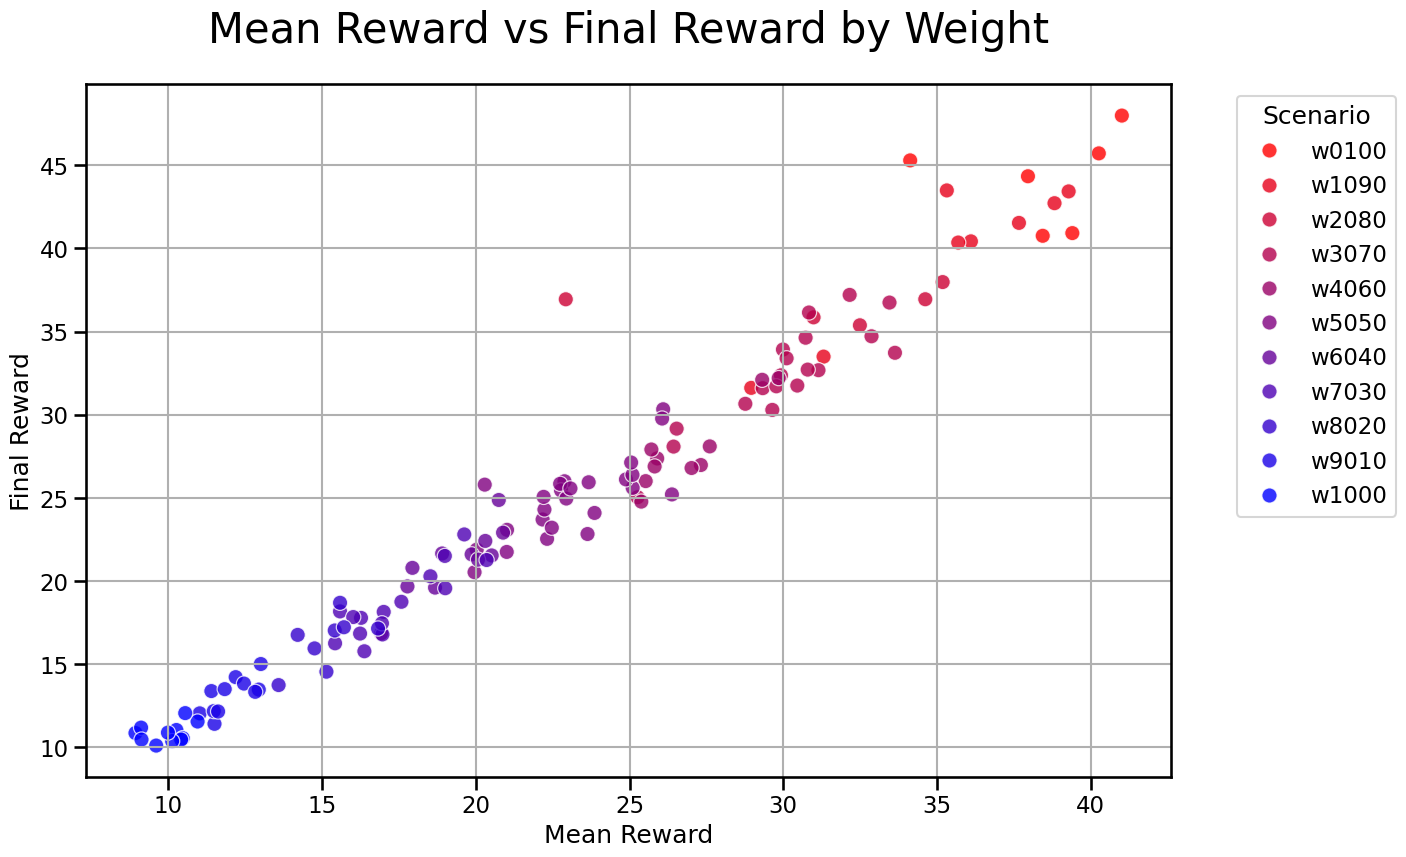

In [ ]:
 # get_reward_data 함수를 WEIGHT_DIR 기반으로 동작하도록 수정합니다.
def get_reward_data(base_dir, weight_folders, well_rewarded_dir):
    """
    지정된 weight_folders 리스트에 있는 가중치들에 대해서만 보상 데이터를 수집합니다.
    """
    reward_data = []
    # WEIGHT_DIR에 지정된 각 가중치에 대해 반복합니다.
    for weight in weight_folders:
           # 각 가중치 폴더에 대한 정확한 검색 경로를 만듭니다.
           search_pattern = os.path.join(base_dir, weight, well_rewarded_dir, '**','training_metrics.xlsx')
           metric_files = glob.glob(search_pattern, recursive=True)

           for file_path in metric_files:
               try:
                   df_summary = pd.read_excel(file_path, sheet_name='Summary_Statistics',index_col=0)
                   final_reward = df_summary.loc['Final Reward', 'Value']
                   mean_reward = df_summary.loc['Mean Reward', 'Value']

                   reward_data.append({
                       'weight': weight, # 경로에서 추출하는 대신, 현재 루프의 weight변수를 사용
                       'Mean Reward': mean_reward,
                       'Final Reward': final_reward
                   })
               except Exception as e:
                   print(f"Error processing {file_path}: {e}")

    return pd.DataFrame(reward_data)

   # --- 함수 교체 후, 아래 코드를 실행하여 그래프를 다시 그립니다. ---

   # 수정된 함수를 호출합니다. 이제 WEIGHT_DIR에 있는 가중치만 처리합니다.
reward_df = get_reward_data(BASE_DIR, WEIGHT_DIR, WELL_REWARDED_DIR)

# 이제는 WEIGHT_DIR에 있는 가중치만 사용하므로, 기존 색상 팔레트를 그대로 사용할 수있습니다.
weight_palette = {w: weight_color_mapping.get(w, (0,0,0))[:3] for w in WEIGHT_DIR}

# 그래프 그리기
pyplot.figure(figsize=(14, 9))
if not reward_df.empty:
    sns.scatterplot(
        data=reward_df,
        x='Mean Reward',
        y='Final Reward',
        hue='weight',
        palette=weight_palette,
        hue_order=WEIGHT_DIR, # 범례 순서를 WEIGHT_DIR 기준으로 고정
        s=120,
        alpha=0.8
    )

pyplot.title('Mean Reward vs Final Reward by Weight', fontsize=30, pad=30)
pyplot.xlabel('Mean Reward')
pyplot.ylabel('Final Reward')
pyplot.grid(True)
pyplot.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
pyplot.show()